In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3287160, 828)
(3287160, 8)
validation
(389976, 828)
(389976, 8)
test
(483136, 828)
(483136, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/329 [..............................] - ETA: 8:57 - loss: 2.2376 - STD: 0.0707 - MAE: 0.2187

  4/329 [..............................] - ETA: 7s - loss: 2.1373 - STD: 0.0371 - MAE: 0.2187  

  7/329 [..............................] - ETA: 7s - loss: 2.1223 - STD: 0.0339 - MAE: 0.2187

 10/329 [..............................] - ETA: 7s - loss: 2.1131 - STD: 0.0307 - MAE: 0.2186

 13/329 [>.............................] - ETA: 7s - loss: 2.1047 - STD: 0.0259 - MAE: 0.2186

 16/329 [>.............................] - ETA: 7s - loss: 2.0995 - STD: 0.0238 - MAE: 0.2186

 19/329 [>.............................] - ETA: 7s - loss: 2.0949 - STD: 0.0228 - MAE: 0.2185

 22/329 [=>............................] - ETA: 6s - loss: 2.0890 - STD: 0.0212 - MAE: 0.2184

 25/329 [=>............................] - ETA: 6s - loss: 2.0819 - STD: 0.0203 - MAE: 0.2182

 28/329 [=>............................] - ETA: 6s - loss: 2.0734 - STD: 0.0205 - MAE: 0.2180

 31/329 [=>............................] - ETA: 6s - loss: 2.0624 - STD: 0.0220 - MAE: 0.2175

 34/329 [==>...........................] - ETA: 6s - loss: 2.0501 - STD: 0.0244 - MAE: 0.2170

 37/329 [==>...........................] - ETA: 6s - loss: 2.0370 - STD: 0.0275 - MAE: 0.2163

 40/329 [==>...........................] - ETA: 6s - loss: 2.0236 - STD: 0.0306 - MAE: 0.2156

 43/329 [==>...........................] - ETA: 6s - loss: 2.0100 - STD: 0.0335 - MAE: 0.2149

 46/329 [===>..........................] - ETA: 6s - loss: 1.9954 - STD: 0.0363 - MAE: 0.2141

 49/329 [===>..........................] - ETA: 6s - loss: 1.9789 - STD: 0.0393 - MAE: 0.2132

 52/329 [===>..........................] - ETA: 6s - loss: 1.9610 - STD: 0.0422 - MAE: 0.2123

 55/329 [====>.........................] - ETA: 6s - loss: 1.9419 - STD: 0.0453 - MAE: 0.2113

 58/329 [====>.........................] - ETA: 6s - loss: 1.9222 - STD: 0.0486 - MAE: 0.2102

 61/329 [====>.........................] - ETA: 6s - loss: 1.9029 - STD: 0.0520 - MAE: 0.2090

 64/329 [====>.........................] - ETA: 6s - loss: 1.8838 - STD: 0.0554 - MAE: 0.2079

 67/329 [=====>........................] - ETA: 5s - loss: 1.8659 - STD: 0.0587 - MAE: 0.2067

 70/329 [=====>........................] - ETA: 5s - loss: 1.8485 - STD: 0.0619 - MAE: 0.2056

 73/329 [=====>........................] - ETA: 5s - loss: 1.8319 - STD: 0.0650 - MAE: 0.2045

 76/329 [=====>........................] - ETA: 5s - loss: 1.8156 - STD: 0.0679 - MAE: 0.2034

 79/329 [======>.......................] - ETA: 5s - loss: 1.8005 - STD: 0.0707 - MAE: 0.2024

 82/329 [======>.......................] - ETA: 5s - loss: 1.7863 - STD: 0.0733 - MAE: 0.2014

 85/329 [======>.......................] - ETA: 5s - loss: 1.7726 - STD: 0.0757 - MAE: 0.2005

 88/329 [=======>......................] - ETA: 5s - loss: 1.7594 - STD: 0.0781 - MAE: 0.1996

 91/329 [=======>......................] - ETA: 5s - loss: 1.7470 - STD: 0.0804 - MAE: 0.1987

 94/329 [=======>......................] - ETA: 5s - loss: 1.7349 - STD: 0.0826 - MAE: 0.1978

 97/329 [=======>......................] - ETA: 5s - loss: 1.7235 - STD: 0.0847 - MAE: 0.1970

 99/329 [========>.....................] - ETA: 7s - loss: 1.7171 - STD: 0.0861 - MAE: 0.1965

102/329 [========>.....................] - ETA: 7s - loss: 1.7065 - STD: 0.0880 - MAE: 0.1957

105/329 [========>.....................] - ETA: 7s - loss: 1.6966 - STD: 0.0898 - MAE: 0.1950

108/329 [========>.....................] - ETA: 6s - loss: 1.6869 - STD: 0.0916 - MAE: 0.1943

111/329 [=========>....................] - ETA: 6s - loss: 1.6776 - STD: 0.0933 - MAE: 0.1936

114/329 [=========>....................] - ETA: 6s - loss: 1.6686 - STD: 0.0949 - MAE: 0.1929

117/329 [=========>....................] - ETA: 6s - loss: 1.6601 - STD: 0.0964 - MAE: 0.1923

120/329 [=========>....................] - ETA: 6s - loss: 1.6519 - STD: 0.0978 - MAE: 0.1917

123/329 [==========>...................] - ETA: 6s - loss: 1.6437 - STD: 0.0993 - MAE: 0.1911

126/329 [==========>...................] - ETA: 6s - loss: 1.6359 - STD: 0.1007 - MAE: 0.1905

129/329 [==========>...................] - ETA: 6s - loss: 1.6281 - STD: 0.1020 - MAE: 0.1899

132/329 [===========>..................] - ETA: 5s - loss: 1.6209 - STD: 0.1033 - MAE: 0.1894

135/329 [===========>..................] - ETA: 5s - loss: 1.6138 - STD: 0.1045 - MAE: 0.1888

138/329 [===========>..................] - ETA: 5s - loss: 1.6067 - STD: 0.1058 - MAE: 0.1883

141/329 [===========>..................] - ETA: 5s - loss: 1.6001 - STD: 0.1070 - MAE: 0.1878

144/329 [============>.................] - ETA: 5s - loss: 1.5936 - STD: 0.1081 - MAE: 0.1873

147/329 [============>.................] - ETA: 5s - loss: 1.5875 - STD: 0.1092 - MAE: 0.1868

150/329 [============>.................] - ETA: 5s - loss: 1.5812 - STD: 0.1103 - MAE: 0.1863

153/329 [============>.................] - ETA: 5s - loss: 1.5752 - STD: 0.1114 - MAE: 0.1858

156/329 [=============>................] - ETA: 4s - loss: 1.5693 - STD: 0.1124 - MAE: 0.1853

159/329 [=============>................] - ETA: 4s - loss: 1.5638 - STD: 0.1134 - MAE: 0.1849

162/329 [=============>................] - ETA: 4s - loss: 1.5584 - STD: 0.1144 - MAE: 0.1845

165/329 [==============>...............] - ETA: 4s - loss: 1.5530 - STD: 0.1154 - MAE: 0.1840

168/329 [==============>...............] - ETA: 4s - loss: 1.5479 - STD: 0.1163 - MAE: 0.1836

171/329 [==============>...............] - ETA: 4s - loss: 1.5427 - STD: 0.1172 - MAE: 0.1832

174/329 [==============>...............] - ETA: 4s - loss: 1.5377 - STD: 0.1182 - MAE: 0.1828

177/329 [===============>..............] - ETA: 4s - loss: 1.5329 - STD: 0.1190 - MAE: 0.1824

180/329 [===============>..............] - ETA: 4s - loss: 1.5280 - STD: 0.1199 - MAE: 0.1819

183/329 [===============>..............] - ETA: 4s - loss: 1.5234 - STD: 0.1208 - MAE: 0.1816

186/329 [===============>..............] - ETA: 3s - loss: 1.5187 - STD: 0.1216 - MAE: 0.1812

189/329 [================>.............] - ETA: 3s - loss: 1.5143 - STD: 0.1224 - MAE: 0.1808

192/329 [================>.............] - ETA: 3s - loss: 1.5099 - STD: 0.1232 - MAE: 0.1804

195/329 [================>.............] - ETA: 3s - loss: 1.5055 - STD: 0.1240 - MAE: 0.1801

198/329 [=================>............] - ETA: 3s - loss: 1.5013 - STD: 0.1247 - MAE: 0.1797

201/329 [=================>............] - ETA: 3s - loss: 1.4971 - STD: 0.1255 - MAE: 0.1793

204/329 [=================>............] - ETA: 3s - loss: 1.4931 - STD: 0.1262 - MAE: 0.1790

207/329 [=================>............] - ETA: 3s - loss: 1.4891 - STD: 0.1269 - MAE: 0.1787

210/329 [==================>...........] - ETA: 3s - loss: 1.4852 - STD: 0.1276 - MAE: 0.1783

213/329 [==================>...........] - ETA: 3s - loss: 1.4813 - STD: 0.1283 - MAE: 0.1780

216/329 [==================>...........] - ETA: 3s - loss: 1.4776 - STD: 0.1289 - MAE: 0.1777

219/329 [==================>...........] - ETA: 2s - loss: 1.4739 - STD: 0.1296 - MAE: 0.1774

222/329 [===================>..........] - ETA: 2s - loss: 1.4703 - STD: 0.1302 - MAE: 0.1770

225/329 [===================>..........] - ETA: 2s - loss: 1.4666 - STD: 0.1309 - MAE: 0.1767

228/329 [===================>..........] - ETA: 2s - loss: 1.4633 - STD: 0.1315 - MAE: 0.1764

231/329 [====================>.........] - ETA: 2s - loss: 1.4598 - STD: 0.1322 - MAE: 0.1761

234/329 [====================>.........] - ETA: 2s - loss: 1.4564 - STD: 0.1328 - MAE: 0.1758

237/329 [====================>.........] - ETA: 2s - loss: 1.4530 - STD: 0.1333 - MAE: 0.1755

240/329 [====================>.........] - ETA: 2s - loss: 1.4496 - STD: 0.1339 - MAE: 0.1752

243/329 [=====================>........] - ETA: 2s - loss: 1.4463 - STD: 0.1345 - MAE: 0.1750

246/329 [=====================>........] - ETA: 2s - loss: 1.4431 - STD: 0.1351 - MAE: 0.1747

249/329 [=====================>........] - ETA: 2s - loss: 1.4401 - STD: 0.1356 - MAE: 0.1744

252/329 [=====================>........] - ETA: 2s - loss: 1.4370 - STD: 0.1362 - MAE: 0.1741

255/329 [======================>.......] - ETA: 1s - loss: 1.4339 - STD: 0.1367 - MAE: 0.1739

258/329 [======================>.......] - ETA: 1s - loss: 1.4308 - STD: 0.1372 - MAE: 0.1736

261/329 [======================>.......] - ETA: 1s - loss: 1.4279 - STD: 0.1377 - MAE: 0.1733

264/329 [=======================>......] - ETA: 1s - loss: 1.4249 - STD: 0.1383 - MAE: 0.1730

267/329 [=======================>......] - ETA: 1s - loss: 1.4219 - STD: 0.1388 - MAE: 0.1728

270/329 [=======================>......] - ETA: 1s - loss: 1.4191 - STD: 0.1393 - MAE: 0.1725

273/329 [=======================>......] - ETA: 1s - loss: 1.4162 - STD: 0.1398 - MAE: 0.1723

276/329 [========================>.....] - ETA: 1s - loss: 1.4134 - STD: 0.1403 - MAE: 0.1720

279/329 [========================>.....] - ETA: 1s - loss: 1.4108 - STD: 0.1407 - MAE: 0.1718

282/329 [========================>.....] - ETA: 1s - loss: 1.4083 - STD: 0.1412 - MAE: 0.1715

285/329 [========================>.....] - ETA: 1s - loss: 1.4056 - STD: 0.1417 - MAE: 0.1713

288/329 [=========================>....] - ETA: 1s - loss: 1.4031 - STD: 0.1421 - MAE: 0.1711

291/329 [=========================>....] - ETA: 0s - loss: 1.4004 - STD: 0.1426 - MAE: 0.1708

294/329 [=========================>....] - ETA: 0s - loss: 1.3978 - STD: 0.1430 - MAE: 0.1706

297/329 [==========================>...] - ETA: 0s - loss: 1.3952 - STD: 0.1435 - MAE: 0.1704

300/329 [==========================>...] - ETA: 0s - loss: 1.3927 - STD: 0.1439 - MAE: 0.1701

303/329 [==========================>...] - ETA: 0s - loss: 1.3902 - STD: 0.1443 - MAE: 0.1699

306/329 [==========================>...] - ETA: 0s - loss: 1.3877 - STD: 0.1448 - MAE: 0.1697

309/329 [===========================>..] - ETA: 0s - loss: 1.3854 - STD: 0.1452 - MAE: 0.1695

312/329 [===========================>..] - ETA: 0s - loss: 1.3830 - STD: 0.1456 - MAE: 0.1692

315/329 [===========================>..] - ETA: 0s - loss: 1.3805 - STD: 0.1460 - MAE: 0.1690

318/329 [===========================>..] - ETA: 0s - loss: 1.3783 - STD: 0.1464 - MAE: 0.1688

321/329 [============================>.] - ETA: 0s - loss: 1.3760 - STD: 0.1468 - MAE: 0.1686

324/329 [============================>.] - ETA: 0s - loss: 1.3737 - STD: 0.1472 - MAE: 0.1684

327/329 [============================>.] - ETA: 0s - loss: 1.3714 - STD: 0.1476 - MAE: 0.1682

329/329 [==============================] - 11s 30ms/step - loss: 1.3699 - STD: 0.1478 - MAE: 0.1680 - val_loss: 1.2238 - val_STD: 0.1894 - val_MAE: 0.1467


Epoch 2/10000


  1/329 [..............................] - ETA: 15s - loss: 1.1244 - STD: 0.1899 - MAE: 0.1454

  4/329 [..............................] - ETA: 7s - loss: 1.1139 - STD: 0.1897 - MAE: 0.1449 

  7/329 [..............................] - ETA: 7s - loss: 1.1148 - STD: 0.1895 - MAE: 0.1449

 10/329 [..............................] - ETA: 7s - loss: 1.1173 - STD: 0.1896 - MAE: 0.1451

 13/329 [>.............................] - ETA: 7s - loss: 1.1166 - STD: 0.1896 - MAE: 0.1450

 16/329 [>.............................] - ETA: 7s - loss: 1.1177 - STD: 0.1897 - MAE: 0.1451

 19/329 [>.............................] - ETA: 7s - loss: 1.1170 - STD: 0.1898 - MAE: 0.1450

 22/329 [=>............................] - ETA: 6s - loss: 1.1168 - STD: 0.1899 - MAE: 0.1449

 25/329 [=>............................] - ETA: 6s - loss: 1.1165 - STD: 0.1900 - MAE: 0.1449

 28/329 [=>............................] - ETA: 6s - loss: 1.1158 - STD: 0.1901 - MAE: 0.1448

 31/329 [=>............................] - ETA: 6s - loss: 1.1137 - STD: 0.1902 - MAE: 0.1446

 34/329 [==>...........................] - ETA: 6s - loss: 1.1128 - STD: 0.1904 - MAE: 0.1445

 37/329 [==>...........................] - ETA: 6s - loss: 1.1117 - STD: 0.1906 - MAE: 0.1443

 40/329 [==>...........................] - ETA: 6s - loss: 1.1111 - STD: 0.1908 - MAE: 0.1442

 43/329 [==>...........................] - ETA: 6s - loss: 1.1105 - STD: 0.1909 - MAE: 0.1441

 46/329 [===>..........................] - ETA: 6s - loss: 1.1093 - STD: 0.1911 - MAE: 0.1440

 49/329 [===>..........................] - ETA: 6s - loss: 1.1085 - STD: 0.1911 - MAE: 0.1440

 52/329 [===>..........................] - ETA: 6s - loss: 1.1074 - STD: 0.1912 - MAE: 0.1438

 55/329 [====>.........................] - ETA: 6s - loss: 1.1062 - STD: 0.1914 - MAE: 0.1437

 58/329 [====>.........................] - ETA: 6s - loss: 1.1058 - STD: 0.1914 - MAE: 0.1437

 61/329 [====>.........................] - ETA: 6s - loss: 1.1052 - STD: 0.1916 - MAE: 0.1436

 64/329 [====>.........................] - ETA: 6s - loss: 1.1047 - STD: 0.1917 - MAE: 0.1435

 67/329 [=====>........................] - ETA: 5s - loss: 1.1039 - STD: 0.1918 - MAE: 0.1434

 70/329 [=====>........................] - ETA: 5s - loss: 1.1041 - STD: 0.1919 - MAE: 0.1434

 73/329 [=====>........................] - ETA: 5s - loss: 1.1031 - STD: 0.1920 - MAE: 0.1433

 76/329 [=====>........................] - ETA: 5s - loss: 1.1028 - STD: 0.1921 - MAE: 0.1433

 79/329 [======>.......................] - ETA: 5s - loss: 1.1018 - STD: 0.1921 - MAE: 0.1432

 82/329 [======>.......................] - ETA: 5s - loss: 1.1013 - STD: 0.1922 - MAE: 0.1431

 85/329 [======>.......................] - ETA: 5s - loss: 1.1001 - STD: 0.1923 - MAE: 0.1430

 88/329 [=======>......................] - ETA: 5s - loss: 1.0997 - STD: 0.1925 - MAE: 0.1429

 91/329 [=======>......................] - ETA: 5s - loss: 1.0993 - STD: 0.1926 - MAE: 0.1429

 94/329 [=======>......................] - ETA: 5s - loss: 1.0985 - STD: 0.1927 - MAE: 0.1428

 97/329 [=======>......................] - ETA: 5s - loss: 1.0973 - STD: 0.1928 - MAE: 0.1427

100/329 [========>.....................] - ETA: 5s - loss: 1.0964 - STD: 0.1929 - MAE: 0.1426

103/329 [========>.....................] - ETA: 5s - loss: 1.0958 - STD: 0.1930 - MAE: 0.1425

106/329 [========>.....................] - ETA: 5s - loss: 1.0950 - STD: 0.1931 - MAE: 0.1424

109/329 [========>.....................] - ETA: 4s - loss: 1.0941 - STD: 0.1932 - MAE: 0.1424

112/329 [=========>....................] - ETA: 4s - loss: 1.0934 - STD: 0.1933 - MAE: 0.1423

115/329 [=========>....................] - ETA: 4s - loss: 1.0923 - STD: 0.1934 - MAE: 0.1422

118/329 [=========>....................] - ETA: 4s - loss: 1.0918 - STD: 0.1935 - MAE: 0.1421

121/329 [==========>...................] - ETA: 4s - loss: 1.0913 - STD: 0.1936 - MAE: 0.1420

124/329 [==========>...................] - ETA: 4s - loss: 1.0904 - STD: 0.1937 - MAE: 0.1420

127/329 [==========>...................] - ETA: 4s - loss: 1.0898 - STD: 0.1938 - MAE: 0.1419

130/329 [==========>...................] - ETA: 4s - loss: 1.0894 - STD: 0.1939 - MAE: 0.1418

133/329 [===========>..................] - ETA: 4s - loss: 1.0889 - STD: 0.1940 - MAE: 0.1417

136/329 [===========>..................] - ETA: 4s - loss: 1.0882 - STD: 0.1941 - MAE: 0.1417

139/329 [===========>..................] - ETA: 4s - loss: 1.0875 - STD: 0.1942 - MAE: 0.1416

142/329 [===========>..................] - ETA: 4s - loss: 1.0869 - STD: 0.1943 - MAE: 0.1415

145/329 [============>.................] - ETA: 4s - loss: 1.0862 - STD: 0.1944 - MAE: 0.1414

148/329 [============>.................] - ETA: 4s - loss: 1.0856 - STD: 0.1945 - MAE: 0.1414

151/329 [============>.................] - ETA: 4s - loss: 1.0848 - STD: 0.1945 - MAE: 0.1413

154/329 [=============>................] - ETA: 3s - loss: 1.0842 - STD: 0.1946 - MAE: 0.1412

157/329 [=============>................] - ETA: 3s - loss: 1.0834 - STD: 0.1947 - MAE: 0.1412

160/329 [=============>................] - ETA: 3s - loss: 1.0826 - STD: 0.1948 - MAE: 0.1411

163/329 [=============>................] - ETA: 3s - loss: 1.0818 - STD: 0.1949 - MAE: 0.1410

166/329 [==============>...............] - ETA: 3s - loss: 1.0813 - STD: 0.1950 - MAE: 0.1409

169/329 [==============>...............] - ETA: 3s - loss: 1.0815 - STD: 0.1951 - MAE: 0.1409

172/329 [==============>...............] - ETA: 3s - loss: 1.0812 - STD: 0.1952 - MAE: 0.1408

175/329 [==============>...............] - ETA: 3s - loss: 1.0806 - STD: 0.1953 - MAE: 0.1408

178/329 [===============>..............] - ETA: 3s - loss: 1.0799 - STD: 0.1954 - MAE: 0.1407

181/329 [===============>..............] - ETA: 3s - loss: 1.0793 - STD: 0.1955 - MAE: 0.1406

184/329 [===============>..............] - ETA: 3s - loss: 1.0788 - STD: 0.1955 - MAE: 0.1406

187/329 [================>.............] - ETA: 3s - loss: 1.0782 - STD: 0.1956 - MAE: 0.1405

190/329 [================>.............] - ETA: 3s - loss: 1.0775 - STD: 0.1957 - MAE: 0.1405

193/329 [================>.............] - ETA: 3s - loss: 1.0769 - STD: 0.1958 - MAE: 0.1404

196/329 [================>.............] - ETA: 3s - loss: 1.0764 - STD: 0.1959 - MAE: 0.1403

199/329 [=================>............] - ETA: 2s - loss: 1.0758 - STD: 0.1960 - MAE: 0.1403

202/329 [=================>............] - ETA: 2s - loss: 1.0751 - STD: 0.1960 - MAE: 0.1402

205/329 [=================>............] - ETA: 2s - loss: 1.0747 - STD: 0.1961 - MAE: 0.1401

208/329 [=================>............] - ETA: 2s - loss: 1.0745 - STD: 0.1962 - MAE: 0.1401

211/329 [==================>...........] - ETA: 2s - loss: 1.0740 - STD: 0.1963 - MAE: 0.1400

214/329 [==================>...........] - ETA: 2s - loss: 1.0737 - STD: 0.1963 - MAE: 0.1400

217/329 [==================>...........] - ETA: 2s - loss: 1.0731 - STD: 0.1964 - MAE: 0.1399

220/329 [===================>..........] - ETA: 2s - loss: 1.0726 - STD: 0.1965 - MAE: 0.1399

223/329 [===================>..........] - ETA: 2s - loss: 1.0720 - STD: 0.1966 - MAE: 0.1398

226/329 [===================>..........] - ETA: 2s - loss: 1.0716 - STD: 0.1967 - MAE: 0.1398

229/329 [===================>..........] - ETA: 2s - loss: 1.0711 - STD: 0.1967 - MAE: 0.1397

232/329 [====================>.........] - ETA: 2s - loss: 1.0705 - STD: 0.1968 - MAE: 0.1396

235/329 [====================>.........] - ETA: 2s - loss: 1.0700 - STD: 0.1969 - MAE: 0.1396

238/329 [====================>.........] - ETA: 2s - loss: 1.0693 - STD: 0.1970 - MAE: 0.1395

241/329 [====================>.........] - ETA: 1s - loss: 1.0689 - STD: 0.1970 - MAE: 0.1394

244/329 [=====================>........] - ETA: 1s - loss: 1.0686 - STD: 0.1971 - MAE: 0.1394

247/329 [=====================>........] - ETA: 1s - loss: 1.0681 - STD: 0.1972 - MAE: 0.1393

250/329 [=====================>........] - ETA: 1s - loss: 1.0676 - STD: 0.1973 - MAE: 0.1393

253/329 [======================>.......] - ETA: 1s - loss: 1.0671 - STD: 0.1974 - MAE: 0.1392

256/329 [======================>.......] - ETA: 1s - loss: 1.0665 - STD: 0.1974 - MAE: 0.1392

259/329 [======================>.......] - ETA: 1s - loss: 1.0662 - STD: 0.1975 - MAE: 0.1391

262/329 [======================>.......] - ETA: 1s - loss: 1.0658 - STD: 0.1976 - MAE: 0.1391

265/329 [=======================>......] - ETA: 1s - loss: 1.0653 - STD: 0.1976 - MAE: 0.1390

268/329 [=======================>......] - ETA: 1s - loss: 1.0649 - STD: 0.1977 - MAE: 0.1390

271/329 [=======================>......] - ETA: 1s - loss: 1.0647 - STD: 0.1978 - MAE: 0.1389

274/329 [=======================>......] - ETA: 1s - loss: 1.0643 - STD: 0.1978 - MAE: 0.1389

277/329 [========================>.....] - ETA: 1s - loss: 1.0639 - STD: 0.1979 - MAE: 0.1388

280/329 [========================>.....] - ETA: 1s - loss: 1.0634 - STD: 0.1980 - MAE: 0.1388

283/329 [========================>.....] - ETA: 1s - loss: 1.0628 - STD: 0.1980 - MAE: 0.1387

286/329 [=========================>....] - ETA: 0s - loss: 1.0625 - STD: 0.1981 - MAE: 0.1387

289/329 [=========================>....] - ETA: 0s - loss: 1.0620 - STD: 0.1982 - MAE: 0.1386

292/329 [=========================>....] - ETA: 0s - loss: 1.0616 - STD: 0.1983 - MAE: 0.1386

295/329 [=========================>....] - ETA: 0s - loss: 1.0611 - STD: 0.1983 - MAE: 0.1385

298/329 [==========================>...] - ETA: 0s - loss: 1.0606 - STD: 0.1984 - MAE: 0.1384

301/329 [==========================>...] - ETA: 0s - loss: 1.0601 - STD: 0.1985 - MAE: 0.1384

304/329 [==========================>...] - ETA: 0s - loss: 1.0596 - STD: 0.1985 - MAE: 0.1383

307/329 [==========================>...] - ETA: 0s - loss: 1.0592 - STD: 0.1986 - MAE: 0.1383

310/329 [===========================>..] - ETA: 0s - loss: 1.0586 - STD: 0.1987 - MAE: 0.1382

313/329 [===========================>..] - ETA: 0s - loss: 1.0580 - STD: 0.1987 - MAE: 0.1382

316/329 [===========================>..] - ETA: 0s - loss: 1.0574 - STD: 0.1988 - MAE: 0.1381

319/329 [============================>.] - ETA: 0s - loss: 1.0569 - STD: 0.1989 - MAE: 0.1381

322/329 [============================>.] - ETA: 0s - loss: 1.0564 - STD: 0.1989 - MAE: 0.1380

325/329 [============================>.] - ETA: 0s - loss: 1.0558 - STD: 0.1990 - MAE: 0.1379

328/329 [============================>.] - ETA: 0s - loss: 1.0552 - STD: 0.1991 - MAE: 0.1379

329/329 [==============================] - 8s 25ms/step - loss: 1.0550 - STD: 0.1991 - MAE: 0.1378 - val_loss: 1.1337 - val_STD: 0.2063 - val_MAE: 0.1352


Epoch 3/10000


  1/329 [..............................] - ETA: 15s - loss: 1.0133 - STD: 0.2064 - MAE: 0.1327

  4/329 [..............................] - ETA: 7s - loss: 0.9952 - STD: 0.2072 - MAE: 0.1313 

  7/329 [..............................] - ETA: 7s - loss: 0.9966 - STD: 0.2072 - MAE: 0.1314

 10/329 [..............................] - ETA: 7s - loss: 1.0003 - STD: 0.2074 - MAE: 0.1315

 13/329 [>.............................] - ETA: 7s - loss: 1.0059 - STD: 0.2074 - MAE: 0.1318

 16/329 [>.............................] - ETA: 7s - loss: 1.0164 - STD: 0.2076 - MAE: 0.1323

 19/329 [>.............................] - ETA: 7s - loss: 1.0180 - STD: 0.2077 - MAE: 0.1323

 22/329 [=>............................] - ETA: 6s - loss: 1.0186 - STD: 0.2075 - MAE: 0.1324

 25/329 [=>............................] - ETA: 6s - loss: 1.0177 - STD: 0.2074 - MAE: 0.1324

 28/329 [=>............................] - ETA: 6s - loss: 1.0164 - STD: 0.2072 - MAE: 0.1324

 31/329 [=>............................] - ETA: 6s - loss: 1.0147 - STD: 0.2071 - MAE: 0.1323

 34/329 [==>...........................] - ETA: 6s - loss: 1.0120 - STD: 0.2070 - MAE: 0.1322

 37/329 [==>...........................] - ETA: 6s - loss: 1.0109 - STD: 0.2070 - MAE: 0.1322

 40/329 [==>...........................] - ETA: 6s - loss: 1.0090 - STD: 0.2071 - MAE: 0.1320

 43/329 [==>...........................] - ETA: 6s - loss: 1.0080 - STD: 0.2071 - MAE: 0.1320

 46/329 [===>..........................] - ETA: 6s - loss: 1.0072 - STD: 0.2071 - MAE: 0.1319

 49/329 [===>..........................] - ETA: 6s - loss: 1.0068 - STD: 0.2072 - MAE: 0.1318

 52/329 [===>..........................] - ETA: 6s - loss: 1.0059 - STD: 0.2072 - MAE: 0.1318

 55/329 [====>.........................] - ETA: 6s - loss: 1.0050 - STD: 0.2072 - MAE: 0.1317

 58/329 [====>.........................] - ETA: 6s - loss: 1.0046 - STD: 0.2073 - MAE: 0.1317

 61/329 [====>.........................] - ETA: 6s - loss: 1.0040 - STD: 0.2073 - MAE: 0.1316

 64/329 [====>.........................] - ETA: 6s - loss: 1.0040 - STD: 0.2074 - MAE: 0.1316

 67/329 [=====>........................] - ETA: 5s - loss: 1.0042 - STD: 0.2075 - MAE: 0.1316

 70/329 [=====>........................] - ETA: 5s - loss: 1.0044 - STD: 0.2076 - MAE: 0.1316

 73/329 [=====>........................] - ETA: 5s - loss: 1.0051 - STD: 0.2077 - MAE: 0.1316

 76/329 [=====>........................] - ETA: 5s - loss: 1.0053 - STD: 0.2078 - MAE: 0.1316

 79/329 [======>.......................] - ETA: 5s - loss: 1.0050 - STD: 0.2078 - MAE: 0.1315

 82/329 [======>.......................] - ETA: 5s - loss: 1.0044 - STD: 0.2078 - MAE: 0.1315

 85/329 [======>.......................] - ETA: 5s - loss: 1.0037 - STD: 0.2078 - MAE: 0.1315

 88/329 [=======>......................] - ETA: 5s - loss: 1.0030 - STD: 0.2079 - MAE: 0.1314

 91/329 [=======>......................] - ETA: 5s - loss: 1.0024 - STD: 0.2079 - MAE: 0.1313

 94/329 [=======>......................] - ETA: 5s - loss: 1.0015 - STD: 0.2080 - MAE: 0.1313

 97/329 [=======>......................] - ETA: 5s - loss: 1.0011 - STD: 0.2080 - MAE: 0.1313

100/329 [========>.....................] - ETA: 5s - loss: 1.0006 - STD: 0.2080 - MAE: 0.1312

103/329 [========>.....................] - ETA: 5s - loss: 0.9998 - STD: 0.2080 - MAE: 0.1311

106/329 [========>.....................] - ETA: 5s - loss: 0.9995 - STD: 0.2081 - MAE: 0.1311

109/329 [========>.....................] - ETA: 4s - loss: 0.9992 - STD: 0.2082 - MAE: 0.1311

112/329 [=========>....................] - ETA: 4s - loss: 0.9992 - STD: 0.2083 - MAE: 0.1310

115/329 [=========>....................] - ETA: 4s - loss: 0.9990 - STD: 0.2083 - MAE: 0.1310

118/329 [=========>....................] - ETA: 4s - loss: 0.9990 - STD: 0.2084 - MAE: 0.1310

121/329 [==========>...................] - ETA: 4s - loss: 0.9990 - STD: 0.2084 - MAE: 0.1309

124/329 [==========>...................] - ETA: 4s - loss: 0.9988 - STD: 0.2084 - MAE: 0.1309

127/329 [==========>...................] - ETA: 4s - loss: 0.9988 - STD: 0.2085 - MAE: 0.1309

130/329 [==========>...................] - ETA: 4s - loss: 0.9990 - STD: 0.2085 - MAE: 0.1309

133/329 [===========>..................] - ETA: 4s - loss: 0.9987 - STD: 0.2085 - MAE: 0.1309

136/329 [===========>..................] - ETA: 4s - loss: 0.9982 - STD: 0.2086 - MAE: 0.1308

139/329 [===========>..................] - ETA: 4s - loss: 0.9976 - STD: 0.2086 - MAE: 0.1308

142/329 [===========>..................] - ETA: 4s - loss: 0.9969 - STD: 0.2086 - MAE: 0.1307

145/329 [============>.................] - ETA: 4s - loss: 0.9963 - STD: 0.2087 - MAE: 0.1307

148/329 [============>.................] - ETA: 4s - loss: 0.9957 - STD: 0.2087 - MAE: 0.1306

151/329 [============>.................] - ETA: 4s - loss: 0.9953 - STD: 0.2087 - MAE: 0.1306

154/329 [=============>................] - ETA: 3s - loss: 0.9948 - STD: 0.2087 - MAE: 0.1305

157/329 [=============>................] - ETA: 3s - loss: 0.9942 - STD: 0.2088 - MAE: 0.1305

160/329 [=============>................] - ETA: 3s - loss: 0.9940 - STD: 0.2088 - MAE: 0.1305

163/329 [=============>................] - ETA: 3s - loss: 0.9938 - STD: 0.2089 - MAE: 0.1304

166/329 [==============>...............] - ETA: 3s - loss: 0.9934 - STD: 0.2089 - MAE: 0.1304

169/329 [==============>...............] - ETA: 3s - loss: 0.9929 - STD: 0.2090 - MAE: 0.1303

172/329 [==============>...............] - ETA: 3s - loss: 0.9924 - STD: 0.2090 - MAE: 0.1303

175/329 [==============>...............] - ETA: 3s - loss: 0.9918 - STD: 0.2090 - MAE: 0.1302

178/329 [===============>..............] - ETA: 3s - loss: 0.9912 - STD: 0.2091 - MAE: 0.1302

181/329 [===============>..............] - ETA: 3s - loss: 0.9906 - STD: 0.2091 - MAE: 0.1301

184/329 [===============>..............] - ETA: 3s - loss: 0.9900 - STD: 0.2092 - MAE: 0.1301

187/329 [================>.............] - ETA: 3s - loss: 0.9894 - STD: 0.2092 - MAE: 0.1300

190/329 [================>.............] - ETA: 3s - loss: 0.9891 - STD: 0.2093 - MAE: 0.1300

193/329 [================>.............] - ETA: 3s - loss: 0.9885 - STD: 0.2094 - MAE: 0.1299

196/329 [================>.............] - ETA: 3s - loss: 0.9881 - STD: 0.2094 - MAE: 0.1299

199/329 [=================>............] - ETA: 2s - loss: 0.9876 - STD: 0.2094 - MAE: 0.1298

202/329 [=================>............] - ETA: 2s - loss: 0.9874 - STD: 0.2095 - MAE: 0.1298

205/329 [=================>............] - ETA: 2s - loss: 0.9871 - STD: 0.2096 - MAE: 0.1297

208/329 [=================>............] - ETA: 2s - loss: 0.9867 - STD: 0.2096 - MAE: 0.1297

211/329 [==================>...........] - ETA: 2s - loss: 0.9862 - STD: 0.2096 - MAE: 0.1297

214/329 [==================>...........] - ETA: 2s - loss: 0.9859 - STD: 0.2097 - MAE: 0.1296

217/329 [==================>...........] - ETA: 2s - loss: 0.9854 - STD: 0.2097 - MAE: 0.1296

220/329 [===================>..........] - ETA: 2s - loss: 0.9852 - STD: 0.2098 - MAE: 0.1295

223/329 [===================>..........] - ETA: 2s - loss: 0.9851 - STD: 0.2098 - MAE: 0.1295

226/329 [===================>..........] - ETA: 2s - loss: 0.9849 - STD: 0.2099 - MAE: 0.1295

229/329 [===================>..........] - ETA: 2s - loss: 0.9844 - STD: 0.2099 - MAE: 0.1294

232/329 [====================>.........] - ETA: 2s - loss: 0.9840 - STD: 0.2100 - MAE: 0.1294

235/329 [====================>.........] - ETA: 2s - loss: 0.9838 - STD: 0.2100 - MAE: 0.1294

238/329 [====================>.........] - ETA: 2s - loss: 0.9835 - STD: 0.2100 - MAE: 0.1293

241/329 [====================>.........] - ETA: 1s - loss: 0.9832 - STD: 0.2101 - MAE: 0.1293

244/329 [=====================>........] - ETA: 1s - loss: 0.9827 - STD: 0.2101 - MAE: 0.1292

247/329 [=====================>........] - ETA: 1s - loss: 0.9822 - STD: 0.2102 - MAE: 0.1292

250/329 [=====================>........] - ETA: 1s - loss: 0.9817 - STD: 0.2102 - MAE: 0.1291

253/329 [======================>.......] - ETA: 1s - loss: 0.9813 - STD: 0.2103 - MAE: 0.1291

256/329 [======================>.......] - ETA: 1s - loss: 0.9808 - STD: 0.2103 - MAE: 0.1291

259/329 [======================>.......] - ETA: 1s - loss: 0.9803 - STD: 0.2104 - MAE: 0.1290

262/329 [======================>.......] - ETA: 1s - loss: 0.9806 - STD: 0.2104 - MAE: 0.1290

265/329 [=======================>......] - ETA: 1s - loss: 0.9805 - STD: 0.2105 - MAE: 0.1290

268/329 [=======================>......] - ETA: 1s - loss: 0.9805 - STD: 0.2105 - MAE: 0.1289

271/329 [=======================>......] - ETA: 1s - loss: 0.9805 - STD: 0.2106 - MAE: 0.1289

274/329 [=======================>......] - ETA: 1s - loss: 0.9803 - STD: 0.2106 - MAE: 0.1289

277/329 [========================>.....] - ETA: 1s - loss: 0.9801 - STD: 0.2107 - MAE: 0.1289

280/329 [========================>.....] - ETA: 1s - loss: 0.9799 - STD: 0.2107 - MAE: 0.1288

283/329 [========================>.....] - ETA: 1s - loss: 0.9798 - STD: 0.2107 - MAE: 0.1288

286/329 [=========================>....] - ETA: 0s - loss: 0.9796 - STD: 0.2107 - MAE: 0.1288

289/329 [=========================>....] - ETA: 0s - loss: 0.9795 - STD: 0.2108 - MAE: 0.1288

292/329 [=========================>....] - ETA: 0s - loss: 0.9792 - STD: 0.2108 - MAE: 0.1287

295/329 [=========================>....] - ETA: 0s - loss: 0.9789 - STD: 0.2108 - MAE: 0.1287

298/329 [==========================>...] - ETA: 0s - loss: 0.9784 - STD: 0.2109 - MAE: 0.1287

301/329 [==========================>...] - ETA: 0s - loss: 0.9781 - STD: 0.2109 - MAE: 0.1286

304/329 [==========================>...] - ETA: 0s - loss: 0.9777 - STD: 0.2110 - MAE: 0.1286

307/329 [==========================>...] - ETA: 0s - loss: 0.9773 - STD: 0.2110 - MAE: 0.1285

310/329 [===========================>..] - ETA: 0s - loss: 0.9770 - STD: 0.2110 - MAE: 0.1285

313/329 [===========================>..] - ETA: 0s - loss: 0.9766 - STD: 0.2111 - MAE: 0.1285

316/329 [===========================>..] - ETA: 0s - loss: 0.9762 - STD: 0.2111 - MAE: 0.1284

319/329 [============================>.] - ETA: 0s - loss: 0.9759 - STD: 0.2111 - MAE: 0.1284

322/329 [============================>.] - ETA: 0s - loss: 0.9757 - STD: 0.2112 - MAE: 0.1284

325/329 [============================>.] - ETA: 0s - loss: 0.9754 - STD: 0.2112 - MAE: 0.1283

328/329 [============================>.] - ETA: 0s - loss: 0.9750 - STD: 0.2112 - MAE: 0.1283

329/329 [==============================] - 8s 25ms/step - loss: 0.9749 - STD: 0.2113 - MAE: 0.1283 - val_loss: 1.0997 - val_STD: 0.2162 - val_MAE: 0.1292


Epoch 4/10000


  1/329 [..............................] - ETA: 16s - loss: 0.9323 - STD: 0.2167 - MAE: 0.1233

  4/329 [..............................] - ETA: 7s - loss: 0.9372 - STD: 0.2166 - MAE: 0.1238 

  7/329 [..............................] - ETA: 7s - loss: 0.9343 - STD: 0.2164 - MAE: 0.1237

 10/329 [..............................] - ETA: 7s - loss: 0.9380 - STD: 0.2161 - MAE: 0.1241

 13/329 [>.............................] - ETA: 7s - loss: 0.9344 - STD: 0.2163 - MAE: 0.1237

 16/329 [>.............................] - ETA: 7s - loss: 0.9344 - STD: 0.2162 - MAE: 0.1238

 19/329 [>.............................] - ETA: 7s - loss: 0.9328 - STD: 0.2162 - MAE: 0.1237

 22/329 [=>............................] - ETA: 6s - loss: 0.9324 - STD: 0.2162 - MAE: 0.1236

 25/329 [=>............................] - ETA: 6s - loss: 0.9335 - STD: 0.2162 - MAE: 0.1237

 28/329 [=>............................] - ETA: 6s - loss: 0.9333 - STD: 0.2162 - MAE: 0.1237

 31/329 [=>............................] - ETA: 6s - loss: 0.9314 - STD: 0.2163 - MAE: 0.1235

 34/329 [==>...........................] - ETA: 6s - loss: 0.9309 - STD: 0.2164 - MAE: 0.1234

 37/329 [==>...........................] - ETA: 6s - loss: 0.9311 - STD: 0.2165 - MAE: 0.1234

 40/329 [==>...........................] - ETA: 6s - loss: 0.9306 - STD: 0.2167 - MAE: 0.1233

 43/329 [==>...........................] - ETA: 6s - loss: 0.9303 - STD: 0.2167 - MAE: 0.1233

 46/329 [===>..........................] - ETA: 6s - loss: 0.9312 - STD: 0.2167 - MAE: 0.1233

 49/329 [===>..........................] - ETA: 6s - loss: 0.9321 - STD: 0.2167 - MAE: 0.1234

 52/329 [===>..........................] - ETA: 6s - loss: 0.9319 - STD: 0.2168 - MAE: 0.1233

 55/329 [====>.........................] - ETA: 6s - loss: 0.9326 - STD: 0.2168 - MAE: 0.1234

 58/329 [====>.........................] - ETA: 6s - loss: 0.9327 - STD: 0.2169 - MAE: 0.1234

 61/329 [====>.........................] - ETA: 6s - loss: 0.9324 - STD: 0.2169 - MAE: 0.1233

 64/329 [====>.........................] - ETA: 6s - loss: 0.9324 - STD: 0.2170 - MAE: 0.1233

 67/329 [=====>........................] - ETA: 5s - loss: 0.9312 - STD: 0.2170 - MAE: 0.1232

 70/329 [=====>........................] - ETA: 5s - loss: 0.9303 - STD: 0.2170 - MAE: 0.1231

 73/329 [=====>........................] - ETA: 5s - loss: 0.9299 - STD: 0.2171 - MAE: 0.1231

 76/329 [=====>........................] - ETA: 5s - loss: 0.9295 - STD: 0.2171 - MAE: 0.1231

 79/329 [======>.......................] - ETA: 5s - loss: 0.9299 - STD: 0.2171 - MAE: 0.1231

 82/329 [======>.......................] - ETA: 5s - loss: 0.9293 - STD: 0.2172 - MAE: 0.1230

 85/329 [======>.......................] - ETA: 5s - loss: 0.9287 - STD: 0.2172 - MAE: 0.1230

 88/329 [=======>......................] - ETA: 5s - loss: 0.9279 - STD: 0.2172 - MAE: 0.1229

 91/329 [=======>......................] - ETA: 5s - loss: 0.9284 - STD: 0.2173 - MAE: 0.1229

 94/329 [=======>......................] - ETA: 5s - loss: 0.9283 - STD: 0.2173 - MAE: 0.1229

 97/329 [=======>......................] - ETA: 5s - loss: 0.9286 - STD: 0.2173 - MAE: 0.1229

100/329 [========>.....................] - ETA: 5s - loss: 0.9289 - STD: 0.2173 - MAE: 0.1229

103/329 [========>.....................] - ETA: 5s - loss: 0.9292 - STD: 0.2174 - MAE: 0.1229

106/329 [========>.....................] - ETA: 5s - loss: 0.9296 - STD: 0.2174 - MAE: 0.1229

109/329 [========>.....................] - ETA: 5s - loss: 0.9303 - STD: 0.2175 - MAE: 0.1230

112/329 [=========>....................] - ETA: 4s - loss: 0.9305 - STD: 0.2175 - MAE: 0.1230

115/329 [=========>....................] - ETA: 4s - loss: 0.9308 - STD: 0.2175 - MAE: 0.1230

118/329 [=========>....................] - ETA: 4s - loss: 0.9309 - STD: 0.2175 - MAE: 0.1230

121/329 [==========>...................] - ETA: 4s - loss: 0.9308 - STD: 0.2175 - MAE: 0.1230

124/329 [==========>...................] - ETA: 4s - loss: 0.9304 - STD: 0.2175 - MAE: 0.1229

127/329 [==========>...................] - ETA: 4s - loss: 0.9306 - STD: 0.2175 - MAE: 0.1229

130/329 [==========>...................] - ETA: 4s - loss: 0.9303 - STD: 0.2176 - MAE: 0.1229

133/329 [===========>..................] - ETA: 4s - loss: 0.9300 - STD: 0.2176 - MAE: 0.1229

136/329 [===========>..................] - ETA: 4s - loss: 0.9300 - STD: 0.2176 - MAE: 0.1229

139/329 [===========>..................] - ETA: 4s - loss: 0.9296 - STD: 0.2176 - MAE: 0.1229

142/329 [===========>..................] - ETA: 4s - loss: 0.9294 - STD: 0.2176 - MAE: 0.1228

145/329 [============>.................] - ETA: 4s - loss: 0.9295 - STD: 0.2176 - MAE: 0.1228

148/329 [============>.................] - ETA: 4s - loss: 0.9292 - STD: 0.2176 - MAE: 0.1228

151/329 [============>.................] - ETA: 4s - loss: 0.9293 - STD: 0.2176 - MAE: 0.1228

154/329 [=============>................] - ETA: 3s - loss: 0.9291 - STD: 0.2177 - MAE: 0.1228

157/329 [=============>................] - ETA: 3s - loss: 0.9288 - STD: 0.2177 - MAE: 0.1228

160/329 [=============>................] - ETA: 3s - loss: 0.9284 - STD: 0.2177 - MAE: 0.1227

163/329 [=============>................] - ETA: 3s - loss: 0.9281 - STD: 0.2177 - MAE: 0.1227

166/329 [==============>...............] - ETA: 3s - loss: 0.9278 - STD: 0.2178 - MAE: 0.1227

169/329 [==============>...............] - ETA: 3s - loss: 0.9276 - STD: 0.2178 - MAE: 0.1226

172/329 [==============>...............] - ETA: 3s - loss: 0.9272 - STD: 0.2178 - MAE: 0.1226

175/329 [==============>...............] - ETA: 3s - loss: 0.9269 - STD: 0.2179 - MAE: 0.1226

178/329 [===============>..............] - ETA: 3s - loss: 0.9266 - STD: 0.2179 - MAE: 0.1225

181/329 [===============>..............] - ETA: 3s - loss: 0.9267 - STD: 0.2179 - MAE: 0.1225

184/329 [===============>..............] - ETA: 3s - loss: 0.9264 - STD: 0.2180 - MAE: 0.1225

187/329 [================>.............] - ETA: 3s - loss: 0.9265 - STD: 0.2180 - MAE: 0.1225

190/329 [================>.............] - ETA: 3s - loss: 0.9263 - STD: 0.2180 - MAE: 0.1225

193/329 [================>.............] - ETA: 3s - loss: 0.9266 - STD: 0.2181 - MAE: 0.1225

196/329 [================>.............] - ETA: 3s - loss: 0.9264 - STD: 0.2181 - MAE: 0.1224

199/329 [=================>............] - ETA: 2s - loss: 0.9261 - STD: 0.2181 - MAE: 0.1224

202/329 [=================>............] - ETA: 2s - loss: 0.9258 - STD: 0.2181 - MAE: 0.1224

205/329 [=================>............] - ETA: 2s - loss: 0.9257 - STD: 0.2181 - MAE: 0.1224

208/329 [=================>............] - ETA: 2s - loss: 0.9253 - STD: 0.2182 - MAE: 0.1223

211/329 [==================>...........] - ETA: 2s - loss: 0.9252 - STD: 0.2182 - MAE: 0.1223

214/329 [==================>...........] - ETA: 2s - loss: 0.9249 - STD: 0.2182 - MAE: 0.1223

217/329 [==================>...........] - ETA: 2s - loss: 0.9246 - STD: 0.2183 - MAE: 0.1222

220/329 [===================>..........] - ETA: 2s - loss: 0.9247 - STD: 0.2183 - MAE: 0.1222

223/329 [===================>..........] - ETA: 2s - loss: 0.9244 - STD: 0.2183 - MAE: 0.1222

226/329 [===================>..........] - ETA: 2s - loss: 0.9242 - STD: 0.2184 - MAE: 0.1222

229/329 [===================>..........] - ETA: 2s - loss: 0.9239 - STD: 0.2184 - MAE: 0.1221

232/329 [====================>.........] - ETA: 2s - loss: 0.9236 - STD: 0.2184 - MAE: 0.1221

235/329 [====================>.........] - ETA: 2s - loss: 0.9233 - STD: 0.2184 - MAE: 0.1221

238/329 [====================>.........] - ETA: 2s - loss: 0.9230 - STD: 0.2185 - MAE: 0.1221

241/329 [====================>.........] - ETA: 2s - loss: 0.9228 - STD: 0.2185 - MAE: 0.1220

244/329 [=====================>........] - ETA: 1s - loss: 0.9226 - STD: 0.2185 - MAE: 0.1220

247/329 [=====================>........] - ETA: 1s - loss: 0.9222 - STD: 0.2186 - MAE: 0.1220

250/329 [=====================>........] - ETA: 1s - loss: 0.9222 - STD: 0.2186 - MAE: 0.1220

253/329 [======================>.......] - ETA: 1s - loss: 0.9220 - STD: 0.2186 - MAE: 0.1219

256/329 [======================>.......] - ETA: 1s - loss: 0.9219 - STD: 0.2186 - MAE: 0.1219

259/329 [======================>.......] - ETA: 1s - loss: 0.9221 - STD: 0.2187 - MAE: 0.1219

262/329 [======================>.......] - ETA: 1s - loss: 0.9219 - STD: 0.2187 - MAE: 0.1219

265/329 [=======================>......] - ETA: 1s - loss: 0.9220 - STD: 0.2187 - MAE: 0.1219

268/329 [=======================>......] - ETA: 1s - loss: 0.9216 - STD: 0.2188 - MAE: 0.1219

271/329 [=======================>......] - ETA: 1s - loss: 0.9214 - STD: 0.2188 - MAE: 0.1218

274/329 [=======================>......] - ETA: 1s - loss: 0.9210 - STD: 0.2188 - MAE: 0.1218

277/329 [========================>.....] - ETA: 1s - loss: 0.9207 - STD: 0.2188 - MAE: 0.1218

280/329 [========================>.....] - ETA: 1s - loss: 0.9204 - STD: 0.2189 - MAE: 0.1217

283/329 [========================>.....] - ETA: 1s - loss: 0.9201 - STD: 0.2189 - MAE: 0.1217

286/329 [=========================>....] - ETA: 0s - loss: 0.9200 - STD: 0.2189 - MAE: 0.1217

289/329 [=========================>....] - ETA: 0s - loss: 0.9199 - STD: 0.2189 - MAE: 0.1217

292/329 [=========================>....] - ETA: 0s - loss: 0.9201 - STD: 0.2190 - MAE: 0.1217

295/329 [=========================>....] - ETA: 0s - loss: 0.9199 - STD: 0.2190 - MAE: 0.1216

298/329 [==========================>...] - ETA: 0s - loss: 0.9197 - STD: 0.2190 - MAE: 0.1216

301/329 [==========================>...] - ETA: 0s - loss: 0.9196 - STD: 0.2191 - MAE: 0.1216

304/329 [==========================>...] - ETA: 0s - loss: 0.9195 - STD: 0.2191 - MAE: 0.1216

307/329 [==========================>...] - ETA: 0s - loss: 0.9196 - STD: 0.2191 - MAE: 0.1216

310/329 [===========================>..] - ETA: 0s - loss: 0.9193 - STD: 0.2192 - MAE: 0.1215

313/329 [===========================>..] - ETA: 0s - loss: 0.9190 - STD: 0.2192 - MAE: 0.1215

316/329 [===========================>..] - ETA: 0s - loss: 0.9189 - STD: 0.2192 - MAE: 0.1215

319/329 [============================>.] - ETA: 0s - loss: 0.9186 - STD: 0.2192 - MAE: 0.1215

322/329 [============================>.] - ETA: 0s - loss: 0.9184 - STD: 0.2192 - MAE: 0.1214

325/329 [============================>.] - ETA: 0s - loss: 0.9182 - STD: 0.2193 - MAE: 0.1214

328/329 [============================>.] - ETA: 0s - loss: 0.9182 - STD: 0.2193 - MAE: 0.1214

329/329 [==============================] - 8s 25ms/step - loss: 0.9181 - STD: 0.2193 - MAE: 0.1214 - val_loss: 1.0946 - val_STD: 0.2202 - val_MAE: 0.1269


Epoch 5/10000


  1/329 [..............................] - ETA: 15s - loss: 0.9061 - STD: 0.2208 - MAE: 0.1200

  4/329 [..............................] - ETA: 7s - loss: 0.8907 - STD: 0.2213 - MAE: 0.1188 

  7/329 [..............................] - ETA: 7s - loss: 0.8966 - STD: 0.2217 - MAE: 0.1189

 10/329 [..............................] - ETA: 7s - loss: 0.8976 - STD: 0.2219 - MAE: 0.1189

 13/329 [>.............................] - ETA: 7s - loss: 0.8925 - STD: 0.2219 - MAE: 0.1185

 16/329 [>.............................] - ETA: 7s - loss: 0.8912 - STD: 0.2221 - MAE: 0.1184

 19/329 [>.............................] - ETA: 7s - loss: 0.8918 - STD: 0.2221 - MAE: 0.1185

 22/329 [=>............................] - ETA: 6s - loss: 0.8909 - STD: 0.2221 - MAE: 0.1184

 25/329 [=>............................] - ETA: 6s - loss: 0.8889 - STD: 0.2222 - MAE: 0.1182

 28/329 [=>............................] - ETA: 6s - loss: 0.8895 - STD: 0.2222 - MAE: 0.1183

 31/329 [=>............................] - ETA: 6s - loss: 0.8899 - STD: 0.2223 - MAE: 0.1183

 34/329 [==>...........................] - ETA: 6s - loss: 0.8893 - STD: 0.2223 - MAE: 0.1182

 37/329 [==>...........................] - ETA: 6s - loss: 0.8898 - STD: 0.2224 - MAE: 0.1182

 40/329 [==>...........................] - ETA: 6s - loss: 0.8892 - STD: 0.2224 - MAE: 0.1182

 43/329 [==>...........................] - ETA: 6s - loss: 0.8912 - STD: 0.2226 - MAE: 0.1182

 46/329 [===>..........................] - ETA: 6s - loss: 0.8916 - STD: 0.2226 - MAE: 0.1182

 49/329 [===>..........................] - ETA: 6s - loss: 0.8920 - STD: 0.2228 - MAE: 0.1182

 52/329 [===>..........................] - ETA: 6s - loss: 0.8914 - STD: 0.2227 - MAE: 0.1182

 55/329 [====>.........................] - ETA: 6s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1181

 58/329 [====>.........................] - ETA: 6s - loss: 0.8908 - STD: 0.2228 - MAE: 0.1181

 61/329 [====>.........................] - ETA: 6s - loss: 0.8904 - STD: 0.2229 - MAE: 0.1181

 64/329 [====>.........................] - ETA: 6s - loss: 0.8905 - STD: 0.2229 - MAE: 0.1181

 67/329 [=====>........................] - ETA: 5s - loss: 0.8904 - STD: 0.2229 - MAE: 0.1180

 70/329 [=====>........................] - ETA: 5s - loss: 0.8905 - STD: 0.2229 - MAE: 0.1180

 73/329 [=====>........................] - ETA: 5s - loss: 0.8911 - STD: 0.2229 - MAE: 0.1181

 76/329 [=====>........................] - ETA: 5s - loss: 0.8919 - STD: 0.2230 - MAE: 0.1181

 79/329 [======>.......................] - ETA: 5s - loss: 0.8920 - STD: 0.2230 - MAE: 0.1181

 82/329 [======>.......................] - ETA: 5s - loss: 0.8922 - STD: 0.2230 - MAE: 0.1181

 85/329 [======>.......................] - ETA: 5s - loss: 0.8917 - STD: 0.2230 - MAE: 0.1181

 88/329 [=======>......................] - ETA: 5s - loss: 0.8912 - STD: 0.2230 - MAE: 0.1181

 91/329 [=======>......................] - ETA: 5s - loss: 0.8906 - STD: 0.2230 - MAE: 0.1180

 94/329 [=======>......................] - ETA: 5s - loss: 0.8900 - STD: 0.2230 - MAE: 0.1180

 97/329 [=======>......................] - ETA: 5s - loss: 0.8897 - STD: 0.2230 - MAE: 0.1179

100/329 [========>.....................] - ETA: 5s - loss: 0.8900 - STD: 0.2231 - MAE: 0.1179

103/329 [========>.....................] - ETA: 5s - loss: 0.8900 - STD: 0.2231 - MAE: 0.1179

106/329 [========>.....................] - ETA: 5s - loss: 0.8899 - STD: 0.2231 - MAE: 0.1179

109/329 [========>.....................] - ETA: 5s - loss: 0.8896 - STD: 0.2232 - MAE: 0.1179

112/329 [=========>....................] - ETA: 4s - loss: 0.8892 - STD: 0.2232 - MAE: 0.1178

115/329 [=========>....................] - ETA: 4s - loss: 0.8887 - STD: 0.2232 - MAE: 0.1178

118/329 [=========>....................] - ETA: 4s - loss: 0.8885 - STD: 0.2233 - MAE: 0.1178

121/329 [==========>...................] - ETA: 4s - loss: 0.8883 - STD: 0.2233 - MAE: 0.1177

124/329 [==========>...................] - ETA: 4s - loss: 0.8882 - STD: 0.2233 - MAE: 0.1177

127/329 [==========>...................] - ETA: 4s - loss: 0.8882 - STD: 0.2233 - MAE: 0.1177

130/329 [==========>...................] - ETA: 4s - loss: 0.8882 - STD: 0.2234 - MAE: 0.1177

133/329 [===========>..................] - ETA: 4s - loss: 0.8878 - STD: 0.2234 - MAE: 0.1177

136/329 [===========>..................] - ETA: 4s - loss: 0.8879 - STD: 0.2234 - MAE: 0.1176

139/329 [===========>..................] - ETA: 4s - loss: 0.8882 - STD: 0.2234 - MAE: 0.1177

142/329 [===========>..................] - ETA: 4s - loss: 0.8890 - STD: 0.2235 - MAE: 0.1177

145/329 [============>.................] - ETA: 4s - loss: 0.8888 - STD: 0.2235 - MAE: 0.1177

148/329 [============>.................] - ETA: 4s - loss: 0.8889 - STD: 0.2235 - MAE: 0.1177

151/329 [============>.................] - ETA: 4s - loss: 0.8888 - STD: 0.2235 - MAE: 0.1177

154/329 [=============>................] - ETA: 3s - loss: 0.8884 - STD: 0.2235 - MAE: 0.1176

157/329 [=============>................] - ETA: 3s - loss: 0.8878 - STD: 0.2235 - MAE: 0.1176

160/329 [=============>................] - ETA: 3s - loss: 0.8875 - STD: 0.2236 - MAE: 0.1176

163/329 [=============>................] - ETA: 3s - loss: 0.8871 - STD: 0.2236 - MAE: 0.1175

166/329 [==============>...............] - ETA: 3s - loss: 0.8868 - STD: 0.2236 - MAE: 0.1175

169/329 [==============>...............] - ETA: 3s - loss: 0.8863 - STD: 0.2236 - MAE: 0.1175

172/329 [==============>...............] - ETA: 3s - loss: 0.8861 - STD: 0.2237 - MAE: 0.1174

175/329 [==============>...............] - ETA: 3s - loss: 0.8858 - STD: 0.2237 - MAE: 0.1174

178/329 [===============>..............] - ETA: 3s - loss: 0.8857 - STD: 0.2237 - MAE: 0.1174

181/329 [===============>..............] - ETA: 3s - loss: 0.8856 - STD: 0.2237 - MAE: 0.1174

184/329 [===============>..............] - ETA: 3s - loss: 0.8854 - STD: 0.2238 - MAE: 0.1174

187/329 [================>.............] - ETA: 3s - loss: 0.8857 - STD: 0.2238 - MAE: 0.1174

190/329 [================>.............] - ETA: 3s - loss: 0.8859 - STD: 0.2238 - MAE: 0.1174

193/329 [================>.............] - ETA: 3s - loss: 0.8856 - STD: 0.2238 - MAE: 0.1174

196/329 [================>.............] - ETA: 3s - loss: 0.8856 - STD: 0.2238 - MAE: 0.1173

199/329 [=================>............] - ETA: 2s - loss: 0.8854 - STD: 0.2238 - MAE: 0.1173

202/329 [=================>............] - ETA: 2s - loss: 0.8851 - STD: 0.2239 - MAE: 0.1173

205/329 [=================>............] - ETA: 2s - loss: 0.8851 - STD: 0.2239 - MAE: 0.1173

208/329 [=================>............] - ETA: 2s - loss: 0.8849 - STD: 0.2239 - MAE: 0.1173

211/329 [==================>...........] - ETA: 2s - loss: 0.8848 - STD: 0.2239 - MAE: 0.1172

214/329 [==================>...........] - ETA: 2s - loss: 0.8846 - STD: 0.2239 - MAE: 0.1172

217/329 [==================>...........] - ETA: 2s - loss: 0.8844 - STD: 0.2239 - MAE: 0.1172

220/329 [===================>..........] - ETA: 2s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1172

223/329 [===================>..........] - ETA: 2s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1172

226/329 [===================>..........] - ETA: 2s - loss: 0.8834 - STD: 0.2240 - MAE: 0.1171

229/329 [===================>..........] - ETA: 2s - loss: 0.8833 - STD: 0.2240 - MAE: 0.1171

232/329 [====================>.........] - ETA: 2s - loss: 0.8832 - STD: 0.2240 - MAE: 0.1171

235/329 [====================>.........] - ETA: 2s - loss: 0.8831 - STD: 0.2241 - MAE: 0.1171

238/329 [====================>.........] - ETA: 2s - loss: 0.8830 - STD: 0.2241 - MAE: 0.1171

241/329 [====================>.........] - ETA: 2s - loss: 0.8827 - STD: 0.2241 - MAE: 0.1170

244/329 [=====================>........] - ETA: 1s - loss: 0.8827 - STD: 0.2241 - MAE: 0.1170

247/329 [=====================>........] - ETA: 1s - loss: 0.8828 - STD: 0.2242 - MAE: 0.1170

250/329 [=====================>........] - ETA: 1s - loss: 0.8827 - STD: 0.2242 - MAE: 0.1170

253/329 [======================>.......] - ETA: 1s - loss: 0.8827 - STD: 0.2242 - MAE: 0.1170

256/329 [======================>.......] - ETA: 1s - loss: 0.8825 - STD: 0.2242 - MAE: 0.1170

259/329 [======================>.......] - ETA: 1s - loss: 0.8824 - STD: 0.2242 - MAE: 0.1170

262/329 [======================>.......] - ETA: 1s - loss: 0.8822 - STD: 0.2242 - MAE: 0.1169

265/329 [=======================>......] - ETA: 1s - loss: 0.8820 - STD: 0.2243 - MAE: 0.1169

268/329 [=======================>......] - ETA: 1s - loss: 0.8817 - STD: 0.2243 - MAE: 0.1169

271/329 [=======================>......] - ETA: 1s - loss: 0.8815 - STD: 0.2243 - MAE: 0.1169

274/329 [=======================>......] - ETA: 1s - loss: 0.8812 - STD: 0.2243 - MAE: 0.1168

277/329 [========================>.....] - ETA: 1s - loss: 0.8809 - STD: 0.2244 - MAE: 0.1168

280/329 [========================>.....] - ETA: 1s - loss: 0.8807 - STD: 0.2244 - MAE: 0.1168

283/329 [========================>.....] - ETA: 1s - loss: 0.8804 - STD: 0.2244 - MAE: 0.1168

286/329 [=========================>....] - ETA: 0s - loss: 0.8802 - STD: 0.2244 - MAE: 0.1167

289/329 [=========================>....] - ETA: 0s - loss: 0.8801 - STD: 0.2244 - MAE: 0.1167

292/329 [=========================>....] - ETA: 0s - loss: 0.8800 - STD: 0.2245 - MAE: 0.1167

295/329 [=========================>....] - ETA: 0s - loss: 0.8798 - STD: 0.2245 - MAE: 0.1167

298/329 [==========================>...] - ETA: 0s - loss: 0.8798 - STD: 0.2245 - MAE: 0.1167

301/329 [==========================>...] - ETA: 0s - loss: 0.8799 - STD: 0.2245 - MAE: 0.1167

304/329 [==========================>...] - ETA: 0s - loss: 0.8797 - STD: 0.2246 - MAE: 0.1166

307/329 [==========================>...] - ETA: 0s - loss: 0.8802 - STD: 0.2246 - MAE: 0.1167

310/329 [===========================>..] - ETA: 0s - loss: 0.8803 - STD: 0.2246 - MAE: 0.1166

313/329 [===========================>..] - ETA: 0s - loss: 0.8804 - STD: 0.2246 - MAE: 0.1166

316/329 [===========================>..] - ETA: 0s - loss: 0.8805 - STD: 0.2247 - MAE: 0.1166

319/329 [============================>.] - ETA: 0s - loss: 0.8804 - STD: 0.2247 - MAE: 0.1166

322/329 [============================>.] - ETA: 0s - loss: 0.8804 - STD: 0.2247 - MAE: 0.1166

325/329 [============================>.] - ETA: 0s - loss: 0.8804 - STD: 0.2247 - MAE: 0.1166

328/329 [============================>.] - ETA: 0s - loss: 0.8803 - STD: 0.2247 - MAE: 0.1166

329/329 [==============================] - 8s 25ms/step - loss: 0.8803 - STD: 0.2247 - MAE: 0.1166 - val_loss: 1.0362 - val_STD: 0.2212 - val_MAE: 0.1248


Epoch 6/10000


  1/329 [..............................] - ETA: 15s - loss: 0.8796 - STD: 0.2248 - MAE: 0.1164

  4/329 [..............................] - ETA: 7s - loss: 0.8677 - STD: 0.2250 - MAE: 0.1157 

  7/329 [..............................] - ETA: 7s - loss: 0.8637 - STD: 0.2249 - MAE: 0.1154

 10/329 [..............................] - ETA: 7s - loss: 0.8693 - STD: 0.2251 - MAE: 0.1156

 13/329 [>.............................] - ETA: 7s - loss: 0.8688 - STD: 0.2253 - MAE: 0.1155

 16/329 [>.............................] - ETA: 7s - loss: 0.8680 - STD: 0.2254 - MAE: 0.1154

 19/329 [>.............................] - ETA: 6s - loss: 0.8676 - STD: 0.2258 - MAE: 0.1152

 22/329 [=>............................] - ETA: 6s - loss: 0.8665 - STD: 0.2259 - MAE: 0.1151

 25/329 [=>............................] - ETA: 6s - loss: 0.8665 - STD: 0.2259 - MAE: 0.1151

 28/329 [=>............................] - ETA: 6s - loss: 0.8650 - STD: 0.2259 - MAE: 0.1150

 31/329 [=>............................] - ETA: 6s - loss: 0.8639 - STD: 0.2260 - MAE: 0.1150

 34/329 [==>...........................] - ETA: 6s - loss: 0.8623 - STD: 0.2262 - MAE: 0.1148

 37/329 [==>...........................] - ETA: 6s - loss: 0.8607 - STD: 0.2262 - MAE: 0.1147

 40/329 [==>...........................] - ETA: 6s - loss: 0.8600 - STD: 0.2263 - MAE: 0.1146

 43/329 [==>...........................] - ETA: 6s - loss: 0.8598 - STD: 0.2264 - MAE: 0.1145

 46/329 [===>..........................] - ETA: 6s - loss: 0.8592 - STD: 0.2266 - MAE: 0.1144

 49/329 [===>..........................] - ETA: 6s - loss: 0.8611 - STD: 0.2266 - MAE: 0.1145

 52/329 [===>..........................] - ETA: 6s - loss: 0.8614 - STD: 0.2267 - MAE: 0.1145

 55/329 [====>.........................] - ETA: 6s - loss: 0.8612 - STD: 0.2267 - MAE: 0.1145

 58/329 [====>.........................] - ETA: 6s - loss: 0.8607 - STD: 0.2267 - MAE: 0.1144

 61/329 [====>.........................] - ETA: 6s - loss: 0.8600 - STD: 0.2268 - MAE: 0.1144

 64/329 [====>.........................] - ETA: 5s - loss: 0.8593 - STD: 0.2268 - MAE: 0.1143

 67/329 [=====>........................] - ETA: 5s - loss: 0.8592 - STD: 0.2269 - MAE: 0.1143

 70/329 [=====>........................] - ETA: 5s - loss: 0.8589 - STD: 0.2269 - MAE: 0.1143

 73/329 [=====>........................] - ETA: 5s - loss: 0.8582 - STD: 0.2270 - MAE: 0.1142

 76/329 [=====>........................] - ETA: 5s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1141

 79/329 [======>.......................] - ETA: 5s - loss: 0.8575 - STD: 0.2271 - MAE: 0.1141

 82/329 [======>.......................] - ETA: 5s - loss: 0.8571 - STD: 0.2271 - MAE: 0.1141

 85/329 [======>.......................] - ETA: 5s - loss: 0.8571 - STD: 0.2271 - MAE: 0.1141

 88/329 [=======>......................] - ETA: 5s - loss: 0.8567 - STD: 0.2272 - MAE: 0.1140

 91/329 [=======>......................] - ETA: 5s - loss: 0.8567 - STD: 0.2272 - MAE: 0.1140

 94/329 [=======>......................] - ETA: 5s - loss: 0.8567 - STD: 0.2272 - MAE: 0.1140

 97/329 [=======>......................] - ETA: 5s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1140

100/329 [========>.....................] - ETA: 5s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1140

103/329 [========>.....................] - ETA: 5s - loss: 0.8581 - STD: 0.2274 - MAE: 0.1140

106/329 [========>.....................] - ETA: 5s - loss: 0.8582 - STD: 0.2274 - MAE: 0.1140

109/329 [========>.....................] - ETA: 4s - loss: 0.8587 - STD: 0.2274 - MAE: 0.1140

112/329 [=========>....................] - ETA: 4s - loss: 0.8585 - STD: 0.2274 - MAE: 0.1140

115/329 [=========>....................] - ETA: 4s - loss: 0.8584 - STD: 0.2274 - MAE: 0.1140

118/329 [=========>....................] - ETA: 4s - loss: 0.8580 - STD: 0.2274 - MAE: 0.1140

121/329 [==========>...................] - ETA: 4s - loss: 0.8574 - STD: 0.2274 - MAE: 0.1139

124/329 [==========>...................] - ETA: 4s - loss: 0.8570 - STD: 0.2274 - MAE: 0.1139

127/329 [==========>...................] - ETA: 4s - loss: 0.8568 - STD: 0.2274 - MAE: 0.1139

130/329 [==========>...................] - ETA: 4s - loss: 0.8566 - STD: 0.2274 - MAE: 0.1139

133/329 [===========>..................] - ETA: 4s - loss: 0.8563 - STD: 0.2275 - MAE: 0.1138

136/329 [===========>..................] - ETA: 4s - loss: 0.8576 - STD: 0.2275 - MAE: 0.1139

139/329 [===========>..................] - ETA: 4s - loss: 0.8578 - STD: 0.2275 - MAE: 0.1139

142/329 [===========>..................] - ETA: 4s - loss: 0.8591 - STD: 0.2275 - MAE: 0.1140

145/329 [============>.................] - ETA: 4s - loss: 0.8592 - STD: 0.2275 - MAE: 0.1140

148/329 [============>.................] - ETA: 4s - loss: 0.8594 - STD: 0.2276 - MAE: 0.1140

151/329 [============>.................] - ETA: 4s - loss: 0.8594 - STD: 0.2276 - MAE: 0.1140

154/329 [=============>................] - ETA: 3s - loss: 0.8591 - STD: 0.2276 - MAE: 0.1139

157/329 [=============>................] - ETA: 3s - loss: 0.8586 - STD: 0.2276 - MAE: 0.1139

160/329 [=============>................] - ETA: 3s - loss: 0.8586 - STD: 0.2276 - MAE: 0.1139

163/329 [=============>................] - ETA: 3s - loss: 0.8585 - STD: 0.2276 - MAE: 0.1139

166/329 [==============>...............] - ETA: 3s - loss: 0.8585 - STD: 0.2276 - MAE: 0.1139

169/329 [==============>...............] - ETA: 3s - loss: 0.8582 - STD: 0.2276 - MAE: 0.1138

172/329 [==============>...............] - ETA: 3s - loss: 0.8579 - STD: 0.2276 - MAE: 0.1138

175/329 [==============>...............] - ETA: 3s - loss: 0.8576 - STD: 0.2277 - MAE: 0.1138

178/329 [===============>..............] - ETA: 3s - loss: 0.8573 - STD: 0.2277 - MAE: 0.1138

181/329 [===============>..............] - ETA: 3s - loss: 0.8569 - STD: 0.2277 - MAE: 0.1137

184/329 [===============>..............] - ETA: 3s - loss: 0.8565 - STD: 0.2277 - MAE: 0.1137

187/329 [================>.............] - ETA: 3s - loss: 0.8563 - STD: 0.2278 - MAE: 0.1137

190/329 [================>.............] - ETA: 3s - loss: 0.8560 - STD: 0.2278 - MAE: 0.1136

193/329 [================>.............] - ETA: 3s - loss: 0.8559 - STD: 0.2278 - MAE: 0.1136

196/329 [================>.............] - ETA: 3s - loss: 0.8558 - STD: 0.2278 - MAE: 0.1136

199/329 [=================>............] - ETA: 2s - loss: 0.8556 - STD: 0.2278 - MAE: 0.1136

202/329 [=================>............] - ETA: 2s - loss: 0.8554 - STD: 0.2279 - MAE: 0.1136

205/329 [=================>............] - ETA: 2s - loss: 0.8552 - STD: 0.2279 - MAE: 0.1136

208/329 [=================>............] - ETA: 2s - loss: 0.8554 - STD: 0.2279 - MAE: 0.1136

211/329 [==================>...........] - ETA: 2s - loss: 0.8552 - STD: 0.2279 - MAE: 0.1135

214/329 [==================>...........] - ETA: 2s - loss: 0.8553 - STD: 0.2279 - MAE: 0.1135

217/329 [==================>...........] - ETA: 2s - loss: 0.8551 - STD: 0.2280 - MAE: 0.1135

220/329 [===================>..........] - ETA: 2s - loss: 0.8552 - STD: 0.2280 - MAE: 0.1135

223/329 [===================>..........] - ETA: 2s - loss: 0.8551 - STD: 0.2280 - MAE: 0.1135

226/329 [===================>..........] - ETA: 2s - loss: 0.8550 - STD: 0.2280 - MAE: 0.1135

229/329 [===================>..........] - ETA: 2s - loss: 0.8548 - STD: 0.2280 - MAE: 0.1135

232/329 [====================>.........] - ETA: 2s - loss: 0.8545 - STD: 0.2280 - MAE: 0.1135

235/329 [====================>.........] - ETA: 2s - loss: 0.8544 - STD: 0.2280 - MAE: 0.1134

238/329 [====================>.........] - ETA: 2s - loss: 0.8542 - STD: 0.2281 - MAE: 0.1134

241/329 [====================>.........] - ETA: 1s - loss: 0.8540 - STD: 0.2281 - MAE: 0.1134

244/329 [=====================>........] - ETA: 1s - loss: 0.8538 - STD: 0.2281 - MAE: 0.1134

247/329 [=====================>........] - ETA: 1s - loss: 0.8541 - STD: 0.2281 - MAE: 0.1134

250/329 [=====================>........] - ETA: 1s - loss: 0.8543 - STD: 0.2281 - MAE: 0.1134

253/329 [======================>.......] - ETA: 1s - loss: 0.8543 - STD: 0.2281 - MAE: 0.1134

256/329 [======================>.......] - ETA: 1s - loss: 0.8543 - STD: 0.2281 - MAE: 0.1134

259/329 [======================>.......] - ETA: 1s - loss: 0.8542 - STD: 0.2281 - MAE: 0.1134

262/329 [======================>.......] - ETA: 1s - loss: 0.8541 - STD: 0.2282 - MAE: 0.1134

265/329 [=======================>......] - ETA: 1s - loss: 0.8541 - STD: 0.2282 - MAE: 0.1134

268/329 [=======================>......] - ETA: 1s - loss: 0.8538 - STD: 0.2282 - MAE: 0.1133

271/329 [=======================>......] - ETA: 1s - loss: 0.8536 - STD: 0.2282 - MAE: 0.1133

274/329 [=======================>......] - ETA: 1s - loss: 0.8534 - STD: 0.2282 - MAE: 0.1133

277/329 [========================>.....] - ETA: 1s - loss: 0.8531 - STD: 0.2282 - MAE: 0.1133

280/329 [========================>.....] - ETA: 1s - loss: 0.8529 - STD: 0.2282 - MAE: 0.1133

283/329 [========================>.....] - ETA: 1s - loss: 0.8526 - STD: 0.2282 - MAE: 0.1132

286/329 [=========================>....] - ETA: 0s - loss: 0.8524 - STD: 0.2283 - MAE: 0.1132

289/329 [=========================>....] - ETA: 0s - loss: 0.8522 - STD: 0.2283 - MAE: 0.1132

292/329 [=========================>....] - ETA: 0s - loss: 0.8519 - STD: 0.2283 - MAE: 0.1132

295/329 [=========================>....] - ETA: 0s - loss: 0.8517 - STD: 0.2283 - MAE: 0.1131

298/329 [==========================>...] - ETA: 0s - loss: 0.8515 - STD: 0.2283 - MAE: 0.1131

301/329 [==========================>...] - ETA: 0s - loss: 0.8519 - STD: 0.2284 - MAE: 0.1131

304/329 [==========================>...] - ETA: 0s - loss: 0.8521 - STD: 0.2284 - MAE: 0.1131

307/329 [==========================>...] - ETA: 0s - loss: 0.8525 - STD: 0.2284 - MAE: 0.1131

310/329 [===========================>..] - ETA: 0s - loss: 0.8525 - STD: 0.2284 - MAE: 0.1131

313/329 [===========================>..] - ETA: 0s - loss: 0.8526 - STD: 0.2285 - MAE: 0.1131

316/329 [===========================>..] - ETA: 0s - loss: 0.8527 - STD: 0.2285 - MAE: 0.1131

319/329 [============================>.] - ETA: 0s - loss: 0.8525 - STD: 0.2285 - MAE: 0.1131

322/329 [============================>.] - ETA: 0s - loss: 0.8523 - STD: 0.2285 - MAE: 0.1131

325/329 [============================>.] - ETA: 0s - loss: 0.8520 - STD: 0.2285 - MAE: 0.1131

328/329 [============================>.] - ETA: 0s - loss: 0.8518 - STD: 0.2285 - MAE: 0.1131

329/329 [==============================] - 8s 25ms/step - loss: 0.8518 - STD: 0.2285 - MAE: 0.1131 - val_loss: 1.0633 - val_STD: 0.2251 - val_MAE: 0.1229


Epoch 7/10000


  1/329 [..............................] - ETA: 12s - loss: 0.8284 - STD: 0.2289 - MAE: 0.1118

  3/329 [..............................] - ETA: 8s - loss: 0.8358 - STD: 0.2287 - MAE: 0.1121 

  6/329 [..............................] - ETA: 7s - loss: 0.8353 - STD: 0.2296 - MAE: 0.1116

  9/329 [..............................] - ETA: 7s - loss: 0.8329 - STD: 0.2297 - MAE: 0.1113

 12/329 [>.............................] - ETA: 7s - loss: 0.8328 - STD: 0.2298 - MAE: 0.1112

 15/329 [>.............................] - ETA: 7s - loss: 0.8327 - STD: 0.2300 - MAE: 0.1111

 18/329 [>.............................] - ETA: 7s - loss: 0.8338 - STD: 0.2301 - MAE: 0.1112

 21/329 [>.............................] - ETA: 7s - loss: 0.8320 - STD: 0.2302 - MAE: 0.1110

 24/329 [=>............................] - ETA: 7s - loss: 0.8324 - STD: 0.2303 - MAE: 0.1110

 27/329 [=>............................] - ETA: 7s - loss: 0.8332 - STD: 0.2304 - MAE: 0.1110

 30/329 [=>............................] - ETA: 6s - loss: 0.8338 - STD: 0.2305 - MAE: 0.1110

 33/329 [==>...........................] - ETA: 6s - loss: 0.8332 - STD: 0.2305 - MAE: 0.1109

 36/329 [==>...........................] - ETA: 6s - loss: 0.8336 - STD: 0.2305 - MAE: 0.1110

 39/329 [==>...........................] - ETA: 6s - loss: 0.8333 - STD: 0.2305 - MAE: 0.1109

 42/329 [==>...........................] - ETA: 6s - loss: 0.8334 - STD: 0.2305 - MAE: 0.1110

 45/329 [===>..........................] - ETA: 6s - loss: 0.8336 - STD: 0.2305 - MAE: 0.1109

 48/329 [===>..........................] - ETA: 6s - loss: 0.8332 - STD: 0.2306 - MAE: 0.1109

 51/329 [===>..........................] - ETA: 6s - loss: 0.8330 - STD: 0.2306 - MAE: 0.1109

 54/329 [===>..........................] - ETA: 6s - loss: 0.8319 - STD: 0.2306 - MAE: 0.1108

 57/329 [====>.........................] - ETA: 6s - loss: 0.8321 - STD: 0.2306 - MAE: 0.1108

 60/329 [====>.........................] - ETA: 6s - loss: 0.8335 - STD: 0.2306 - MAE: 0.1109

 63/329 [====>.........................] - ETA: 6s - loss: 0.8338 - STD: 0.2306 - MAE: 0.1109

 66/329 [=====>........................] - ETA: 6s - loss: 0.8337 - STD: 0.2306 - MAE: 0.1109

 69/329 [=====>........................] - ETA: 5s - loss: 0.8332 - STD: 0.2306 - MAE: 0.1109

 72/329 [=====>........................] - ETA: 5s - loss: 0.8328 - STD: 0.2306 - MAE: 0.1109

 75/329 [=====>........................] - ETA: 5s - loss: 0.8324 - STD: 0.2306 - MAE: 0.1108

 78/329 [======>.......................] - ETA: 5s - loss: 0.8325 - STD: 0.2307 - MAE: 0.1108

 81/329 [======>.......................] - ETA: 5s - loss: 0.8325 - STD: 0.2307 - MAE: 0.1108

 84/329 [======>.......................] - ETA: 5s - loss: 0.8331 - STD: 0.2307 - MAE: 0.1108

 87/329 [======>.......................] - ETA: 5s - loss: 0.8328 - STD: 0.2308 - MAE: 0.1108

 90/329 [=======>......................] - ETA: 5s - loss: 0.8323 - STD: 0.2307 - MAE: 0.1108

 93/329 [=======>......................] - ETA: 5s - loss: 0.8318 - STD: 0.2308 - MAE: 0.1107

 96/329 [=======>......................] - ETA: 5s - loss: 0.8316 - STD: 0.2308 - MAE: 0.1107

 99/329 [========>.....................] - ETA: 5s - loss: 0.8313 - STD: 0.2308 - MAE: 0.1107

102/329 [========>.....................] - ETA: 5s - loss: 0.8312 - STD: 0.2309 - MAE: 0.1106

105/329 [========>.....................] - ETA: 5s - loss: 0.8311 - STD: 0.2309 - MAE: 0.1106

108/329 [========>.....................] - ETA: 5s - loss: 0.8319 - STD: 0.2309 - MAE: 0.1107

111/329 [=========>....................] - ETA: 5s - loss: 0.8316 - STD: 0.2310 - MAE: 0.1106

114/329 [=========>....................] - ETA: 4s - loss: 0.8313 - STD: 0.2310 - MAE: 0.1106

117/329 [=========>....................] - ETA: 4s - loss: 0.8311 - STD: 0.2310 - MAE: 0.1106

120/329 [=========>....................] - ETA: 4s - loss: 0.8308 - STD: 0.2310 - MAE: 0.1105

123/329 [==========>...................] - ETA: 4s - loss: 0.8303 - STD: 0.2310 - MAE: 0.1105

126/329 [==========>...................] - ETA: 4s - loss: 0.8299 - STD: 0.2310 - MAE: 0.1105

129/329 [==========>...................] - ETA: 4s - loss: 0.8297 - STD: 0.2311 - MAE: 0.1105

132/329 [===========>..................] - ETA: 4s - loss: 0.8294 - STD: 0.2311 - MAE: 0.1104

135/329 [===========>..................] - ETA: 4s - loss: 0.8293 - STD: 0.2311 - MAE: 0.1104

138/329 [===========>..................] - ETA: 4s - loss: 0.8295 - STD: 0.2311 - MAE: 0.1104

141/329 [===========>..................] - ETA: 4s - loss: 0.8294 - STD: 0.2312 - MAE: 0.1104

144/329 [============>.................] - ETA: 4s - loss: 0.8293 - STD: 0.2312 - MAE: 0.1104

147/329 [============>.................] - ETA: 4s - loss: 0.8294 - STD: 0.2312 - MAE: 0.1104

150/329 [============>.................] - ETA: 4s - loss: 0.8294 - STD: 0.2312 - MAE: 0.1104

153/329 [============>.................] - ETA: 4s - loss: 0.8295 - STD: 0.2312 - MAE: 0.1104

156/329 [=============>................] - ETA: 3s - loss: 0.8295 - STD: 0.2313 - MAE: 0.1103

159/329 [=============>................] - ETA: 3s - loss: 0.8297 - STD: 0.2313 - MAE: 0.1104

162/329 [=============>................] - ETA: 3s - loss: 0.8296 - STD: 0.2313 - MAE: 0.1103

165/329 [==============>...............] - ETA: 3s - loss: 0.8297 - STD: 0.2313 - MAE: 0.1103

168/329 [==============>...............] - ETA: 3s - loss: 0.8295 - STD: 0.2313 - MAE: 0.1103

171/329 [==============>...............] - ETA: 3s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1103

174/329 [==============>...............] - ETA: 3s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1103

177/329 [===============>..............] - ETA: 3s - loss: 0.8291 - STD: 0.2314 - MAE: 0.1103

180/329 [===============>..............] - ETA: 3s - loss: 0.8287 - STD: 0.2314 - MAE: 0.1102

183/329 [===============>..............] - ETA: 3s - loss: 0.8288 - STD: 0.2314 - MAE: 0.1103

186/329 [===============>..............] - ETA: 3s - loss: 0.8286 - STD: 0.2314 - MAE: 0.1102

189/329 [================>.............] - ETA: 3s - loss: 0.8287 - STD: 0.2314 - MAE: 0.1102

192/329 [================>.............] - ETA: 3s - loss: 0.8285 - STD: 0.2314 - MAE: 0.1102

195/329 [================>.............] - ETA: 3s - loss: 0.8283 - STD: 0.2314 - MAE: 0.1102

198/329 [=================>............] - ETA: 3s - loss: 0.8281 - STD: 0.2314 - MAE: 0.1102

201/329 [=================>............] - ETA: 2s - loss: 0.8282 - STD: 0.2314 - MAE: 0.1102

204/329 [=================>............] - ETA: 2s - loss: 0.8281 - STD: 0.2315 - MAE: 0.1102

207/329 [=================>............] - ETA: 2s - loss: 0.8278 - STD: 0.2315 - MAE: 0.1101

210/329 [==================>...........] - ETA: 2s - loss: 0.8276 - STD: 0.2315 - MAE: 0.1101

213/329 [==================>...........] - ETA: 2s - loss: 0.8274 - STD: 0.2315 - MAE: 0.1101

216/329 [==================>...........] - ETA: 2s - loss: 0.8272 - STD: 0.2315 - MAE: 0.1101

219/329 [==================>...........] - ETA: 2s - loss: 0.8271 - STD: 0.2316 - MAE: 0.1101

222/329 [===================>..........] - ETA: 2s - loss: 0.8270 - STD: 0.2316 - MAE: 0.1100

225/329 [===================>..........] - ETA: 2s - loss: 0.8268 - STD: 0.2316 - MAE: 0.1100

228/329 [===================>..........] - ETA: 2s - loss: 0.8269 - STD: 0.2316 - MAE: 0.1100

231/329 [====================>.........] - ETA: 2s - loss: 0.8269 - STD: 0.2316 - MAE: 0.1100

234/329 [====================>.........] - ETA: 2s - loss: 0.8268 - STD: 0.2317 - MAE: 0.1100

237/329 [====================>.........] - ETA: 2s - loss: 0.8267 - STD: 0.2317 - MAE: 0.1100

240/329 [====================>.........] - ETA: 2s - loss: 0.8264 - STD: 0.2317 - MAE: 0.1100

243/329 [=====================>........] - ETA: 1s - loss: 0.8262 - STD: 0.2317 - MAE: 0.1099

246/329 [=====================>........] - ETA: 1s - loss: 0.8262 - STD: 0.2317 - MAE: 0.1099

249/329 [=====================>........] - ETA: 1s - loss: 0.8260 - STD: 0.2317 - MAE: 0.1099

252/329 [=====================>........] - ETA: 1s - loss: 0.8257 - STD: 0.2317 - MAE: 0.1099

255/329 [======================>.......] - ETA: 1s - loss: 0.8257 - STD: 0.2318 - MAE: 0.1099

258/329 [======================>.......] - ETA: 1s - loss: 0.8257 - STD: 0.2318 - MAE: 0.1099

261/329 [======================>.......] - ETA: 1s - loss: 0.8256 - STD: 0.2318 - MAE: 0.1099

264/329 [=======================>......] - ETA: 1s - loss: 0.8254 - STD: 0.2318 - MAE: 0.1098

267/329 [=======================>......] - ETA: 1s - loss: 0.8253 - STD: 0.2318 - MAE: 0.1098

270/329 [=======================>......] - ETA: 1s - loss: 0.8252 - STD: 0.2318 - MAE: 0.1098

273/329 [=======================>......] - ETA: 1s - loss: 0.8253 - STD: 0.2318 - MAE: 0.1098

276/329 [========================>.....] - ETA: 1s - loss: 0.8252 - STD: 0.2319 - MAE: 0.1098

279/329 [========================>.....] - ETA: 1s - loss: 0.8250 - STD: 0.2319 - MAE: 0.1098

282/329 [========================>.....] - ETA: 1s - loss: 0.8248 - STD: 0.2319 - MAE: 0.1098

285/329 [========================>.....] - ETA: 1s - loss: 0.8247 - STD: 0.2319 - MAE: 0.1097

288/329 [=========================>....] - ETA: 0s - loss: 0.8246 - STD: 0.2319 - MAE: 0.1097

291/329 [=========================>....] - ETA: 0s - loss: 0.8244 - STD: 0.2319 - MAE: 0.1097

294/329 [=========================>....] - ETA: 0s - loss: 0.8241 - STD: 0.2319 - MAE: 0.1097

297/329 [==========================>...] - ETA: 0s - loss: 0.8240 - STD: 0.2320 - MAE: 0.1097

300/329 [==========================>...] - ETA: 0s - loss: 0.8238 - STD: 0.2320 - MAE: 0.1096

303/329 [==========================>...] - ETA: 0s - loss: 0.8239 - STD: 0.2320 - MAE: 0.1096

306/329 [==========================>...] - ETA: 0s - loss: 0.8242 - STD: 0.2320 - MAE: 0.1096

309/329 [===========================>..] - ETA: 0s - loss: 0.8241 - STD: 0.2320 - MAE: 0.1096

312/329 [===========================>..] - ETA: 0s - loss: 0.8240 - STD: 0.2320 - MAE: 0.1096

315/329 [===========================>..] - ETA: 0s - loss: 0.8239 - STD: 0.2320 - MAE: 0.1096

318/329 [===========================>..] - ETA: 0s - loss: 0.8240 - STD: 0.2320 - MAE: 0.1096

321/329 [============================>.] - ETA: 0s - loss: 0.8239 - STD: 0.2321 - MAE: 0.1096

324/329 [============================>.] - ETA: 0s - loss: 0.8237 - STD: 0.2321 - MAE: 0.1096

327/329 [============================>.] - ETA: 0s - loss: 0.8237 - STD: 0.2321 - MAE: 0.1096

329/329 [==============================] - 8s 25ms/step - loss: 0.8236 - STD: 0.2321 - MAE: 0.1096 - val_loss: 0.9900 - val_STD: 0.2285 - val_MAE: 0.1197


Epoch 8/10000


  1/329 [..............................] - ETA: 13s - loss: 0.8217 - STD: 0.2353 - MAE: 0.1077

  4/329 [..............................] - ETA: 7s - loss: 0.8201 - STD: 0.2342 - MAE: 0.1082 

  7/329 [..............................] - ETA: 7s - loss: 0.8178 - STD: 0.2339 - MAE: 0.1082

 10/329 [..............................] - ETA: 7s - loss: 0.8232 - STD: 0.2338 - MAE: 0.1086

 13/329 [>.............................] - ETA: 7s - loss: 0.8154 - STD: 0.2338 - MAE: 0.1081

 16/329 [>.............................] - ETA: 7s - loss: 0.8122 - STD: 0.2337 - MAE: 0.1079

 19/329 [>.............................] - ETA: 6s - loss: 0.8127 - STD: 0.2338 - MAE: 0.1079

 22/329 [=>............................] - ETA: 6s - loss: 0.8130 - STD: 0.2339 - MAE: 0.1080

 25/329 [=>............................] - ETA: 6s - loss: 0.8132 - STD: 0.2338 - MAE: 0.1080

 28/329 [=>............................] - ETA: 6s - loss: 0.8149 - STD: 0.2337 - MAE: 0.1082

 31/329 [=>............................] - ETA: 6s - loss: 0.8148 - STD: 0.2338 - MAE: 0.1082

 34/329 [==>...........................] - ETA: 6s - loss: 0.8141 - STD: 0.2338 - MAE: 0.1081

 37/329 [==>...........................] - ETA: 6s - loss: 0.8137 - STD: 0.2338 - MAE: 0.1081

 40/329 [==>...........................] - ETA: 6s - loss: 0.8147 - STD: 0.2338 - MAE: 0.1081

 43/329 [==>...........................] - ETA: 6s - loss: 0.8164 - STD: 0.2338 - MAE: 0.1083

 46/329 [===>..........................] - ETA: 6s - loss: 0.8163 - STD: 0.2338 - MAE: 0.1083

 49/329 [===>..........................] - ETA: 6s - loss: 0.8149 - STD: 0.2338 - MAE: 0.1082

 52/329 [===>..........................] - ETA: 6s - loss: 0.8157 - STD: 0.2337 - MAE: 0.1083

 55/329 [====>.........................] - ETA: 6s - loss: 0.8154 - STD: 0.2338 - MAE: 0.1082

 58/329 [====>.........................] - ETA: 6s - loss: 0.8166 - STD: 0.2337 - MAE: 0.1083

 61/329 [====>.........................] - ETA: 6s - loss: 0.8159 - STD: 0.2337 - MAE: 0.1083

 64/329 [====>.........................] - ETA: 5s - loss: 0.8162 - STD: 0.2337 - MAE: 0.1083

 67/329 [=====>........................] - ETA: 5s - loss: 0.8158 - STD: 0.2337 - MAE: 0.1083

 70/329 [=====>........................] - ETA: 5s - loss: 0.8153 - STD: 0.2337 - MAE: 0.1083

 73/329 [=====>........................] - ETA: 5s - loss: 0.8145 - STD: 0.2337 - MAE: 0.1082

 76/329 [=====>........................] - ETA: 5s - loss: 0.8142 - STD: 0.2337 - MAE: 0.1082

 79/329 [======>.......................] - ETA: 5s - loss: 0.8135 - STD: 0.2337 - MAE: 0.1081

 82/329 [======>.......................] - ETA: 5s - loss: 0.8136 - STD: 0.2337 - MAE: 0.1081

 85/329 [======>.......................] - ETA: 5s - loss: 0.8137 - STD: 0.2338 - MAE: 0.1081

 88/329 [=======>......................] - ETA: 5s - loss: 0.8142 - STD: 0.2338 - MAE: 0.1081

 91/329 [=======>......................] - ETA: 5s - loss: 0.8139 - STD: 0.2338 - MAE: 0.1081

 94/329 [=======>......................] - ETA: 5s - loss: 0.8142 - STD: 0.2338 - MAE: 0.1081

 97/329 [=======>......................] - ETA: 5s - loss: 0.8142 - STD: 0.2338 - MAE: 0.1081

100/329 [========>.....................] - ETA: 5s - loss: 0.8141 - STD: 0.2338 - MAE: 0.1081

103/329 [========>.....................] - ETA: 5s - loss: 0.8136 - STD: 0.2338 - MAE: 0.1081

106/329 [========>.....................] - ETA: 5s - loss: 0.8137 - STD: 0.2338 - MAE: 0.1081

109/329 [========>.....................] - ETA: 4s - loss: 0.8134 - STD: 0.2338 - MAE: 0.1081

112/329 [=========>....................] - ETA: 4s - loss: 0.8131 - STD: 0.2338 - MAE: 0.1081

115/329 [=========>....................] - ETA: 4s - loss: 0.8131 - STD: 0.2338 - MAE: 0.1081

118/329 [=========>....................] - ETA: 4s - loss: 0.8130 - STD: 0.2338 - MAE: 0.1081

121/329 [==========>...................] - ETA: 4s - loss: 0.8129 - STD: 0.2338 - MAE: 0.1080

124/329 [==========>...................] - ETA: 4s - loss: 0.8134 - STD: 0.2338 - MAE: 0.1081

127/329 [==========>...................] - ETA: 4s - loss: 0.8135 - STD: 0.2339 - MAE: 0.1081

130/329 [==========>...................] - ETA: 4s - loss: 0.8135 - STD: 0.2339 - MAE: 0.1081

133/329 [===========>..................] - ETA: 4s - loss: 0.8130 - STD: 0.2339 - MAE: 0.1080

136/329 [===========>..................] - ETA: 4s - loss: 0.8126 - STD: 0.2339 - MAE: 0.1080

139/329 [===========>..................] - ETA: 4s - loss: 0.8123 - STD: 0.2339 - MAE: 0.1080

142/329 [===========>..................] - ETA: 4s - loss: 0.8123 - STD: 0.2339 - MAE: 0.1080

145/329 [============>.................] - ETA: 4s - loss: 0.8126 - STD: 0.2339 - MAE: 0.1080

148/329 [============>.................] - ETA: 4s - loss: 0.8123 - STD: 0.2340 - MAE: 0.1080

151/329 [============>.................] - ETA: 4s - loss: 0.8122 - STD: 0.2340 - MAE: 0.1079

154/329 [=============>................] - ETA: 3s - loss: 0.8123 - STD: 0.2340 - MAE: 0.1079

157/329 [=============>................] - ETA: 3s - loss: 0.8124 - STD: 0.2340 - MAE: 0.1079

160/329 [=============>................] - ETA: 3s - loss: 0.8123 - STD: 0.2340 - MAE: 0.1079

163/329 [=============>................] - ETA: 3s - loss: 0.8123 - STD: 0.2340 - MAE: 0.1079

166/329 [==============>...............] - ETA: 3s - loss: 0.8125 - STD: 0.2340 - MAE: 0.1079

169/329 [==============>...............] - ETA: 3s - loss: 0.8132 - STD: 0.2340 - MAE: 0.1080

172/329 [==============>...............] - ETA: 3s - loss: 0.8132 - STD: 0.2340 - MAE: 0.1080

175/329 [==============>...............] - ETA: 3s - loss: 0.8130 - STD: 0.2340 - MAE: 0.1080

178/329 [===============>..............] - ETA: 3s - loss: 0.8130 - STD: 0.2340 - MAE: 0.1079

181/329 [===============>..............] - ETA: 3s - loss: 0.8128 - STD: 0.2340 - MAE: 0.1079

184/329 [===============>..............] - ETA: 3s - loss: 0.8124 - STD: 0.2340 - MAE: 0.1079

187/329 [================>.............] - ETA: 3s - loss: 0.8123 - STD: 0.2340 - MAE: 0.1079

190/329 [================>.............] - ETA: 3s - loss: 0.8121 - STD: 0.2340 - MAE: 0.1079

193/329 [================>.............] - ETA: 3s - loss: 0.8118 - STD: 0.2341 - MAE: 0.1079

196/329 [================>.............] - ETA: 3s - loss: 0.8115 - STD: 0.2341 - MAE: 0.1078

199/329 [=================>............] - ETA: 2s - loss: 0.8111 - STD: 0.2341 - MAE: 0.1078

202/329 [=================>............] - ETA: 2s - loss: 0.8107 - STD: 0.2341 - MAE: 0.1078

205/329 [=================>............] - ETA: 2s - loss: 0.8104 - STD: 0.2341 - MAE: 0.1077

208/329 [=================>............] - ETA: 2s - loss: 0.8102 - STD: 0.2342 - MAE: 0.1077

211/329 [==================>...........] - ETA: 2s - loss: 0.8097 - STD: 0.2342 - MAE: 0.1077

214/329 [==================>...........] - ETA: 2s - loss: 0.8096 - STD: 0.2342 - MAE: 0.1076

217/329 [==================>...........] - ETA: 2s - loss: 0.8092 - STD: 0.2342 - MAE: 0.1076

220/329 [===================>..........] - ETA: 2s - loss: 0.8090 - STD: 0.2342 - MAE: 0.1076

223/329 [===================>..........] - ETA: 2s - loss: 0.8087 - STD: 0.2343 - MAE: 0.1076

226/329 [===================>..........] - ETA: 2s - loss: 0.8083 - STD: 0.2343 - MAE: 0.1075

229/329 [===================>..........] - ETA: 2s - loss: 0.8082 - STD: 0.2343 - MAE: 0.1075

232/329 [====================>.........] - ETA: 2s - loss: 0.8081 - STD: 0.2343 - MAE: 0.1075

235/329 [====================>.........] - ETA: 2s - loss: 0.8080 - STD: 0.2343 - MAE: 0.1075

238/329 [====================>.........] - ETA: 2s - loss: 0.8078 - STD: 0.2344 - MAE: 0.1074

241/329 [====================>.........] - ETA: 2s - loss: 0.8075 - STD: 0.2344 - MAE: 0.1074

244/329 [=====================>........] - ETA: 1s - loss: 0.8074 - STD: 0.2344 - MAE: 0.1074

247/329 [=====================>........] - ETA: 1s - loss: 0.8072 - STD: 0.2344 - MAE: 0.1074

250/329 [=====================>........] - ETA: 1s - loss: 0.8070 - STD: 0.2345 - MAE: 0.1074

253/329 [======================>.......] - ETA: 1s - loss: 0.8068 - STD: 0.2345 - MAE: 0.1073

256/329 [======================>.......] - ETA: 1s - loss: 0.8068 - STD: 0.2345 - MAE: 0.1073

259/329 [======================>.......] - ETA: 1s - loss: 0.8067 - STD: 0.2345 - MAE: 0.1073

262/329 [======================>.......] - ETA: 1s - loss: 0.8067 - STD: 0.2345 - MAE: 0.1073

265/329 [=======================>......] - ETA: 1s - loss: 0.8065 - STD: 0.2346 - MAE: 0.1073

268/329 [=======================>......] - ETA: 1s - loss: 0.8066 - STD: 0.2346 - MAE: 0.1073

271/329 [=======================>......] - ETA: 1s - loss: 0.8068 - STD: 0.2346 - MAE: 0.1073

274/329 [=======================>......] - ETA: 1s - loss: 0.8068 - STD: 0.2346 - MAE: 0.1073

277/329 [========================>.....] - ETA: 1s - loss: 0.8068 - STD: 0.2346 - MAE: 0.1073

280/329 [========================>.....] - ETA: 1s - loss: 0.8067 - STD: 0.2346 - MAE: 0.1072

283/329 [========================>.....] - ETA: 1s - loss: 0.8066 - STD: 0.2346 - MAE: 0.1072

286/329 [=========================>....] - ETA: 0s - loss: 0.8067 - STD: 0.2347 - MAE: 0.1072

289/329 [=========================>....] - ETA: 0s - loss: 0.8065 - STD: 0.2347 - MAE: 0.1072

292/329 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2347 - MAE: 0.1072

295/329 [=========================>....] - ETA: 0s - loss: 0.8062 - STD: 0.2347 - MAE: 0.1072

298/329 [==========================>...] - ETA: 0s - loss: 0.8061 - STD: 0.2347 - MAE: 0.1072

301/329 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2347 - MAE: 0.1072

304/329 [==========================>...] - ETA: 0s - loss: 0.8059 - STD: 0.2347 - MAE: 0.1072

307/329 [==========================>...] - ETA: 0s - loss: 0.8058 - STD: 0.2347 - MAE: 0.1071

310/329 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2348 - MAE: 0.1071

313/329 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2348 - MAE: 0.1071

316/329 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2348 - MAE: 0.1071

319/329 [============================>.] - ETA: 0s - loss: 0.8054 - STD: 0.2348 - MAE: 0.1071

322/329 [============================>.] - ETA: 0s - loss: 0.8053 - STD: 0.2348 - MAE: 0.1071

325/329 [============================>.] - ETA: 0s - loss: 0.8052 - STD: 0.2348 - MAE: 0.1071

328/329 [============================>.] - ETA: 0s - loss: 0.8050 - STD: 0.2348 - MAE: 0.1070

329/329 [==============================] - 8s 25ms/step - loss: 0.8050 - STD: 0.2348 - MAE: 0.1070 - val_loss: 1.0107 - val_STD: 0.2299 - val_MAE: 0.1194


Epoch 9/10000


  1/329 [..............................] - ETA: 16s - loss: 0.7818 - STD: 0.2358 - MAE: 0.1048

  4/329 [..............................] - ETA: 7s - loss: 0.7920 - STD: 0.2362 - MAE: 0.1056 

  7/329 [..............................] - ETA: 7s - loss: 0.7871 - STD: 0.2359 - MAE: 0.1055

 10/329 [..............................] - ETA: 7s - loss: 0.7870 - STD: 0.2361 - MAE: 0.1054

 13/329 [>.............................] - ETA: 7s - loss: 0.7856 - STD: 0.2362 - MAE: 0.1052

 16/329 [>.............................] - ETA: 7s - loss: 0.7881 - STD: 0.2363 - MAE: 0.1053

 19/329 [>.............................] - ETA: 7s - loss: 0.7868 - STD: 0.2364 - MAE: 0.1052

 22/329 [=>............................] - ETA: 6s - loss: 0.7893 - STD: 0.2364 - MAE: 0.1053

 25/329 [=>............................] - ETA: 6s - loss: 0.7893 - STD: 0.2364 - MAE: 0.1054

 28/329 [=>............................] - ETA: 6s - loss: 0.7892 - STD: 0.2363 - MAE: 0.1054

 31/329 [=>............................] - ETA: 6s - loss: 0.7897 - STD: 0.2364 - MAE: 0.1054

 34/329 [==>...........................] - ETA: 6s - loss: 0.7905 - STD: 0.2364 - MAE: 0.1054

 37/329 [==>...........................] - ETA: 6s - loss: 0.7913 - STD: 0.2364 - MAE: 0.1055

 40/329 [==>...........................] - ETA: 6s - loss: 0.7902 - STD: 0.2364 - MAE: 0.1054

 43/329 [==>...........................] - ETA: 6s - loss: 0.7902 - STD: 0.2365 - MAE: 0.1053

 46/329 [===>..........................] - ETA: 6s - loss: 0.7901 - STD: 0.2365 - MAE: 0.1053

 49/329 [===>..........................] - ETA: 6s - loss: 0.7900 - STD: 0.2365 - MAE: 0.1053

 52/329 [===>..........................] - ETA: 6s - loss: 0.7898 - STD: 0.2365 - MAE: 0.1053

 55/329 [====>.........................] - ETA: 6s - loss: 0.7898 - STD: 0.2365 - MAE: 0.1053

 58/329 [====>.........................] - ETA: 6s - loss: 0.7893 - STD: 0.2365 - MAE: 0.1052

 61/329 [====>.........................] - ETA: 6s - loss: 0.7891 - STD: 0.2365 - MAE: 0.1052

 64/329 [====>.........................] - ETA: 5s - loss: 0.7889 - STD: 0.2366 - MAE: 0.1052

 67/329 [=====>........................] - ETA: 5s - loss: 0.7882 - STD: 0.2366 - MAE: 0.1051

 70/329 [=====>........................] - ETA: 5s - loss: 0.7878 - STD: 0.2366 - MAE: 0.1051

 73/329 [=====>........................] - ETA: 5s - loss: 0.7875 - STD: 0.2366 - MAE: 0.1051

 76/329 [=====>........................] - ETA: 5s - loss: 0.7891 - STD: 0.2366 - MAE: 0.1052

 79/329 [======>.......................] - ETA: 5s - loss: 0.7896 - STD: 0.2366 - MAE: 0.1052

 82/329 [======>.......................] - ETA: 5s - loss: 0.7900 - STD: 0.2366 - MAE: 0.1052

 85/329 [======>.......................] - ETA: 5s - loss: 0.7903 - STD: 0.2367 - MAE: 0.1052

 88/329 [=======>......................] - ETA: 5s - loss: 0.7899 - STD: 0.2367 - MAE: 0.1052

 91/329 [=======>......................] - ETA: 5s - loss: 0.7900 - STD: 0.2367 - MAE: 0.1052

 94/329 [=======>......................] - ETA: 5s - loss: 0.7900 - STD: 0.2367 - MAE: 0.1052

 97/329 [=======>......................] - ETA: 5s - loss: 0.7896 - STD: 0.2367 - MAE: 0.1052

100/329 [========>.....................] - ETA: 5s - loss: 0.7892 - STD: 0.2367 - MAE: 0.1052

103/329 [========>.....................] - ETA: 5s - loss: 0.7890 - STD: 0.2367 - MAE: 0.1051

106/329 [========>.....................] - ETA: 5s - loss: 0.7889 - STD: 0.2367 - MAE: 0.1051

109/329 [========>.....................] - ETA: 4s - loss: 0.7892 - STD: 0.2367 - MAE: 0.1051

112/329 [=========>....................] - ETA: 4s - loss: 0.7889 - STD: 0.2367 - MAE: 0.1051

115/329 [=========>....................] - ETA: 4s - loss: 0.7888 - STD: 0.2367 - MAE: 0.1051

118/329 [=========>....................] - ETA: 4s - loss: 0.7886 - STD: 0.2367 - MAE: 0.1051

121/329 [==========>...................] - ETA: 4s - loss: 0.7882 - STD: 0.2368 - MAE: 0.1050

124/329 [==========>...................] - ETA: 4s - loss: 0.7883 - STD: 0.2368 - MAE: 0.1050

127/329 [==========>...................] - ETA: 4s - loss: 0.7882 - STD: 0.2368 - MAE: 0.1050

130/329 [==========>...................] - ETA: 4s - loss: 0.7884 - STD: 0.2368 - MAE: 0.1050

133/329 [===========>..................] - ETA: 4s - loss: 0.7882 - STD: 0.2369 - MAE: 0.1050

136/329 [===========>..................] - ETA: 4s - loss: 0.7881 - STD: 0.2369 - MAE: 0.1050

139/329 [===========>..................] - ETA: 4s - loss: 0.7880 - STD: 0.2369 - MAE: 0.1050

142/329 [===========>..................] - ETA: 4s - loss: 0.7881 - STD: 0.2369 - MAE: 0.1050

145/329 [============>.................] - ETA: 4s - loss: 0.7879 - STD: 0.2369 - MAE: 0.1049

148/329 [============>.................] - ETA: 4s - loss: 0.7877 - STD: 0.2369 - MAE: 0.1049

151/329 [============>.................] - ETA: 4s - loss: 0.7877 - STD: 0.2370 - MAE: 0.1049

154/329 [=============>................] - ETA: 3s - loss: 0.7876 - STD: 0.2370 - MAE: 0.1049

157/329 [=============>................] - ETA: 3s - loss: 0.7877 - STD: 0.2370 - MAE: 0.1049

160/329 [=============>................] - ETA: 3s - loss: 0.7876 - STD: 0.2370 - MAE: 0.1049

163/329 [=============>................] - ETA: 3s - loss: 0.7876 - STD: 0.2370 - MAE: 0.1049

166/329 [==============>...............] - ETA: 3s - loss: 0.7877 - STD: 0.2370 - MAE: 0.1049

169/329 [==============>...............] - ETA: 3s - loss: 0.7880 - STD: 0.2370 - MAE: 0.1049

172/329 [==============>...............] - ETA: 3s - loss: 0.7881 - STD: 0.2371 - MAE: 0.1049

175/329 [==============>...............] - ETA: 3s - loss: 0.7883 - STD: 0.2371 - MAE: 0.1049

178/329 [===============>..............] - ETA: 3s - loss: 0.7881 - STD: 0.2371 - MAE: 0.1049

181/329 [===============>..............] - ETA: 3s - loss: 0.7878 - STD: 0.2371 - MAE: 0.1049

184/329 [===============>..............] - ETA: 3s - loss: 0.7878 - STD: 0.2371 - MAE: 0.1049

187/329 [================>.............] - ETA: 3s - loss: 0.7882 - STD: 0.2371 - MAE: 0.1049

190/329 [================>.............] - ETA: 3s - loss: 0.7880 - STD: 0.2371 - MAE: 0.1049

193/329 [================>.............] - ETA: 3s - loss: 0.7878 - STD: 0.2371 - MAE: 0.1049

196/329 [================>.............] - ETA: 3s - loss: 0.7881 - STD: 0.2371 - MAE: 0.1049

199/329 [=================>............] - ETA: 2s - loss: 0.7881 - STD: 0.2371 - MAE: 0.1049

202/329 [=================>............] - ETA: 2s - loss: 0.7881 - STD: 0.2371 - MAE: 0.1049

205/329 [=================>............] - ETA: 2s - loss: 0.7880 - STD: 0.2371 - MAE: 0.1049

208/329 [=================>............] - ETA: 2s - loss: 0.7879 - STD: 0.2371 - MAE: 0.1048

211/329 [==================>...........] - ETA: 2s - loss: 0.7878 - STD: 0.2371 - MAE: 0.1048

214/329 [==================>...........] - ETA: 2s - loss: 0.7878 - STD: 0.2371 - MAE: 0.1048

217/329 [==================>...........] - ETA: 2s - loss: 0.7879 - STD: 0.2371 - MAE: 0.1048

220/329 [===================>..........] - ETA: 2s - loss: 0.7877 - STD: 0.2371 - MAE: 0.1048

223/329 [===================>..........] - ETA: 2s - loss: 0.7875 - STD: 0.2371 - MAE: 0.1048

226/329 [===================>..........] - ETA: 2s - loss: 0.7872 - STD: 0.2371 - MAE: 0.1048

229/329 [===================>..........] - ETA: 2s - loss: 0.7871 - STD: 0.2371 - MAE: 0.1048

232/329 [====================>.........] - ETA: 2s - loss: 0.7873 - STD: 0.2372 - MAE: 0.1048

235/329 [====================>.........] - ETA: 2s - loss: 0.7872 - STD: 0.2372 - MAE: 0.1048

238/329 [====================>.........] - ETA: 2s - loss: 0.7869 - STD: 0.2372 - MAE: 0.1048

241/329 [====================>.........] - ETA: 1s - loss: 0.7867 - STD: 0.2372 - MAE: 0.1047

244/329 [=====================>........] - ETA: 1s - loss: 0.7865 - STD: 0.2372 - MAE: 0.1047

247/329 [=====================>........] - ETA: 1s - loss: 0.7863 - STD: 0.2372 - MAE: 0.1047

250/329 [=====================>........] - ETA: 1s - loss: 0.7861 - STD: 0.2372 - MAE: 0.1047

253/329 [======================>.......] - ETA: 1s - loss: 0.7860 - STD: 0.2372 - MAE: 0.1047

256/329 [======================>.......] - ETA: 1s - loss: 0.7859 - STD: 0.2372 - MAE: 0.1047

259/329 [======================>.......] - ETA: 1s - loss: 0.7858 - STD: 0.2373 - MAE: 0.1046

262/329 [======================>.......] - ETA: 1s - loss: 0.7856 - STD: 0.2373 - MAE: 0.1046

265/329 [=======================>......] - ETA: 1s - loss: 0.7857 - STD: 0.2373 - MAE: 0.1046

268/329 [=======================>......] - ETA: 1s - loss: 0.7855 - STD: 0.2373 - MAE: 0.1046

271/329 [=======================>......] - ETA: 1s - loss: 0.7853 - STD: 0.2373 - MAE: 0.1046

274/329 [=======================>......] - ETA: 1s - loss: 0.7858 - STD: 0.2373 - MAE: 0.1046

277/329 [========================>.....] - ETA: 1s - loss: 0.7857 - STD: 0.2373 - MAE: 0.1046

280/329 [========================>.....] - ETA: 1s - loss: 0.7858 - STD: 0.2373 - MAE: 0.1046

283/329 [========================>.....] - ETA: 1s - loss: 0.7856 - STD: 0.2373 - MAE: 0.1046

286/329 [=========================>....] - ETA: 0s - loss: 0.7857 - STD: 0.2373 - MAE: 0.1046

289/329 [=========================>....] - ETA: 0s - loss: 0.7854 - STD: 0.2374 - MAE: 0.1046

292/329 [=========================>....] - ETA: 0s - loss: 0.7852 - STD: 0.2374 - MAE: 0.1045

295/329 [=========================>....] - ETA: 0s - loss: 0.7849 - STD: 0.2374 - MAE: 0.1045

298/329 [==========================>...] - ETA: 0s - loss: 0.7846 - STD: 0.2374 - MAE: 0.1045

301/329 [==========================>...] - ETA: 0s - loss: 0.7845 - STD: 0.2374 - MAE: 0.1045

304/329 [==========================>...] - ETA: 0s - loss: 0.7844 - STD: 0.2374 - MAE: 0.1045

307/329 [==========================>...] - ETA: 0s - loss: 0.7845 - STD: 0.2374 - MAE: 0.1045

310/329 [===========================>..] - ETA: 0s - loss: 0.7845 - STD: 0.2375 - MAE: 0.1045

313/329 [===========================>..] - ETA: 0s - loss: 0.7845 - STD: 0.2375 - MAE: 0.1045

316/329 [===========================>..] - ETA: 0s - loss: 0.7844 - STD: 0.2375 - MAE: 0.1044

319/329 [============================>.] - ETA: 0s - loss: 0.7841 - STD: 0.2375 - MAE: 0.1044

322/329 [============================>.] - ETA: 0s - loss: 0.7840 - STD: 0.2375 - MAE: 0.1044

325/329 [============================>.] - ETA: 0s - loss: 0.7838 - STD: 0.2375 - MAE: 0.1044

328/329 [============================>.] - ETA: 0s - loss: 0.7836 - STD: 0.2375 - MAE: 0.1044

329/329 [==============================] - 8s 25ms/step - loss: 0.7836 - STD: 0.2375 - MAE: 0.1044 - val_loss: 1.0367 - val_STD: 0.2348 - val_MAE: 0.1190


Epoch 10/10000


  1/329 [..............................] - ETA: 16s - loss: 0.7843 - STD: 0.2399 - MAE: 0.1031

  4/329 [..............................] - ETA: 7s - loss: 0.7674 - STD: 0.2393 - MAE: 0.1024 

  7/329 [..............................] - ETA: 7s - loss: 0.7732 - STD: 0.2393 - MAE: 0.1029

 10/329 [..............................] - ETA: 7s - loss: 0.7696 - STD: 0.2394 - MAE: 0.1026

 13/329 [>.............................] - ETA: 7s - loss: 0.7688 - STD: 0.2394 - MAE: 0.1025

 16/329 [>.............................] - ETA: 7s - loss: 0.7670 - STD: 0.2395 - MAE: 0.1023

 19/329 [>.............................] - ETA: 7s - loss: 0.7649 - STD: 0.2396 - MAE: 0.1022

 22/329 [=>............................] - ETA: 7s - loss: 0.7647 - STD: 0.2396 - MAE: 0.1022

 25/329 [=>............................] - ETA: 6s - loss: 0.7654 - STD: 0.2396 - MAE: 0.1022

 28/329 [=>............................] - ETA: 6s - loss: 0.7667 - STD: 0.2397 - MAE: 0.1023

 31/329 [=>............................] - ETA: 6s - loss: 0.7682 - STD: 0.2398 - MAE: 0.1023

 34/329 [==>...........................] - ETA: 6s - loss: 0.7682 - STD: 0.2398 - MAE: 0.1023

 37/329 [==>...........................] - ETA: 6s - loss: 0.7676 - STD: 0.2397 - MAE: 0.1023

 40/329 [==>...........................] - ETA: 6s - loss: 0.7666 - STD: 0.2397 - MAE: 0.1022

 43/329 [==>...........................] - ETA: 6s - loss: 0.7664 - STD: 0.2397 - MAE: 0.1022

 46/329 [===>..........................] - ETA: 6s - loss: 0.7662 - STD: 0.2398 - MAE: 0.1022

 49/329 [===>..........................] - ETA: 6s - loss: 0.7663 - STD: 0.2397 - MAE: 0.1022

 52/329 [===>..........................] - ETA: 6s - loss: 0.7672 - STD: 0.2397 - MAE: 0.1023

 55/329 [====>.........................] - ETA: 6s - loss: 0.7670 - STD: 0.2397 - MAE: 0.1022

 58/329 [====>.........................] - ETA: 6s - loss: 0.7669 - STD: 0.2396 - MAE: 0.1023

 61/329 [====>.........................] - ETA: 6s - loss: 0.7673 - STD: 0.2396 - MAE: 0.1023

 64/329 [====>.........................] - ETA: 6s - loss: 0.7672 - STD: 0.2396 - MAE: 0.1023

 67/329 [=====>........................] - ETA: 5s - loss: 0.7665 - STD: 0.2396 - MAE: 0.1023

 70/329 [=====>........................] - ETA: 5s - loss: 0.7663 - STD: 0.2395 - MAE: 0.1023

 73/329 [=====>........................] - ETA: 5s - loss: 0.7661 - STD: 0.2395 - MAE: 0.1023

 76/329 [=====>........................] - ETA: 5s - loss: 0.7662 - STD: 0.2395 - MAE: 0.1023

 79/329 [======>.......................] - ETA: 5s - loss: 0.7657 - STD: 0.2396 - MAE: 0.1022

 82/329 [======>.......................] - ETA: 5s - loss: 0.7653 - STD: 0.2396 - MAE: 0.1022

 85/329 [======>.......................] - ETA: 5s - loss: 0.7654 - STD: 0.2396 - MAE: 0.1022

 88/329 [=======>......................] - ETA: 5s - loss: 0.7653 - STD: 0.2396 - MAE: 0.1021

 91/329 [=======>......................] - ETA: 5s - loss: 0.7655 - STD: 0.2397 - MAE: 0.1021

 94/329 [=======>......................] - ETA: 5s - loss: 0.7662 - STD: 0.2397 - MAE: 0.1022

 97/329 [=======>......................] - ETA: 5s - loss: 0.7666 - STD: 0.2398 - MAE: 0.1022

100/329 [========>.....................] - ETA: 5s - loss: 0.7667 - STD: 0.2398 - MAE: 0.1022

103/329 [========>.....................] - ETA: 5s - loss: 0.7675 - STD: 0.2398 - MAE: 0.1022

106/329 [========>.....................] - ETA: 5s - loss: 0.7681 - STD: 0.2398 - MAE: 0.1022

109/329 [========>.....................] - ETA: 4s - loss: 0.7680 - STD: 0.2398 - MAE: 0.1022

112/329 [=========>....................] - ETA: 4s - loss: 0.7677 - STD: 0.2398 - MAE: 0.1022

115/329 [=========>....................] - ETA: 4s - loss: 0.7678 - STD: 0.2397 - MAE: 0.1022

118/329 [=========>....................] - ETA: 4s - loss: 0.7678 - STD: 0.2398 - MAE: 0.1022

121/329 [==========>...................] - ETA: 4s - loss: 0.7679 - STD: 0.2398 - MAE: 0.1022

124/329 [==========>...................] - ETA: 4s - loss: 0.7681 - STD: 0.2397 - MAE: 0.1023

127/329 [==========>...................] - ETA: 4s - loss: 0.7682 - STD: 0.2397 - MAE: 0.1023

130/329 [==========>...................] - ETA: 4s - loss: 0.7683 - STD: 0.2397 - MAE: 0.1023

133/329 [===========>..................] - ETA: 4s - loss: 0.7681 - STD: 0.2397 - MAE: 0.1023

136/329 [===========>..................] - ETA: 4s - loss: 0.7682 - STD: 0.2397 - MAE: 0.1023

139/329 [===========>..................] - ETA: 4s - loss: 0.7682 - STD: 0.2397 - MAE: 0.1023

142/329 [===========>..................] - ETA: 4s - loss: 0.7682 - STD: 0.2397 - MAE: 0.1023

145/329 [============>.................] - ETA: 4s - loss: 0.7679 - STD: 0.2397 - MAE: 0.1023

148/329 [============>.................] - ETA: 4s - loss: 0.7678 - STD: 0.2397 - MAE: 0.1023

151/329 [============>.................] - ETA: 4s - loss: 0.7675 - STD: 0.2397 - MAE: 0.1022

154/329 [=============>................] - ETA: 3s - loss: 0.7677 - STD: 0.2397 - MAE: 0.1023

157/329 [=============>................] - ETA: 3s - loss: 0.7676 - STD: 0.2397 - MAE: 0.1022

160/329 [=============>................] - ETA: 3s - loss: 0.7674 - STD: 0.2397 - MAE: 0.1022

163/329 [=============>................] - ETA: 3s - loss: 0.7680 - STD: 0.2397 - MAE: 0.1023

166/329 [==============>...............] - ETA: 3s - loss: 0.7680 - STD: 0.2397 - MAE: 0.1023

169/329 [==============>...............] - ETA: 3s - loss: 0.7679 - STD: 0.2397 - MAE: 0.1023

172/329 [==============>...............] - ETA: 3s - loss: 0.7678 - STD: 0.2397 - MAE: 0.1023

175/329 [==============>...............] - ETA: 3s - loss: 0.7678 - STD: 0.2397 - MAE: 0.1023

178/329 [===============>..............] - ETA: 3s - loss: 0.7677 - STD: 0.2397 - MAE: 0.1023

181/329 [===============>..............] - ETA: 3s - loss: 0.7677 - STD: 0.2397 - MAE: 0.1023

184/329 [===============>..............] - ETA: 3s - loss: 0.7674 - STD: 0.2397 - MAE: 0.1022

187/329 [================>.............] - ETA: 3s - loss: 0.7675 - STD: 0.2397 - MAE: 0.1022

190/329 [================>.............] - ETA: 3s - loss: 0.7673 - STD: 0.2398 - MAE: 0.1022

193/329 [================>.............] - ETA: 3s - loss: 0.7670 - STD: 0.2398 - MAE: 0.1022

196/329 [================>.............] - ETA: 3s - loss: 0.7668 - STD: 0.2398 - MAE: 0.1022

199/329 [=================>............] - ETA: 2s - loss: 0.7665 - STD: 0.2398 - MAE: 0.1021

202/329 [=================>............] - ETA: 2s - loss: 0.7664 - STD: 0.2398 - MAE: 0.1021

205/329 [=================>............] - ETA: 2s - loss: 0.7663 - STD: 0.2398 - MAE: 0.1021

208/329 [=================>............] - ETA: 2s - loss: 0.7664 - STD: 0.2398 - MAE: 0.1021

211/329 [==================>...........] - ETA: 2s - loss: 0.7663 - STD: 0.2398 - MAE: 0.1021

214/329 [==================>...........] - ETA: 2s - loss: 0.7667 - STD: 0.2398 - MAE: 0.1021

217/329 [==================>...........] - ETA: 2s - loss: 0.7667 - STD: 0.2398 - MAE: 0.1021

220/329 [===================>..........] - ETA: 2s - loss: 0.7665 - STD: 0.2398 - MAE: 0.1021

223/329 [===================>..........] - ETA: 2s - loss: 0.7663 - STD: 0.2399 - MAE: 0.1021

226/329 [===================>..........] - ETA: 2s - loss: 0.7662 - STD: 0.2399 - MAE: 0.1021

229/329 [===================>..........] - ETA: 2s - loss: 0.7661 - STD: 0.2399 - MAE: 0.1021

232/329 [====================>.........] - ETA: 2s - loss: 0.7658 - STD: 0.2399 - MAE: 0.1021

235/329 [====================>.........] - ETA: 2s - loss: 0.7656 - STD: 0.2399 - MAE: 0.1020

238/329 [====================>.........] - ETA: 2s - loss: 0.7654 - STD: 0.2399 - MAE: 0.1020

241/329 [====================>.........] - ETA: 1s - loss: 0.7654 - STD: 0.2399 - MAE: 0.1020

244/329 [=====================>........] - ETA: 1s - loss: 0.7654 - STD: 0.2399 - MAE: 0.1020

247/329 [=====================>........] - ETA: 1s - loss: 0.7652 - STD: 0.2399 - MAE: 0.1020

250/329 [=====================>........] - ETA: 1s - loss: 0.7652 - STD: 0.2399 - MAE: 0.1020

253/329 [======================>.......] - ETA: 1s - loss: 0.7653 - STD: 0.2399 - MAE: 0.1020

256/329 [======================>.......] - ETA: 1s - loss: 0.7652 - STD: 0.2400 - MAE: 0.1020

259/329 [======================>.......] - ETA: 1s - loss: 0.7651 - STD: 0.2400 - MAE: 0.1020

262/329 [======================>.......] - ETA: 1s - loss: 0.7655 - STD: 0.2400 - MAE: 0.1020

265/329 [=======================>......] - ETA: 1s - loss: 0.7658 - STD: 0.2400 - MAE: 0.1020

268/329 [=======================>......] - ETA: 1s - loss: 0.7660 - STD: 0.2400 - MAE: 0.1020

271/329 [=======================>......] - ETA: 1s - loss: 0.7661 - STD: 0.2400 - MAE: 0.1020

274/329 [=======================>......] - ETA: 1s - loss: 0.7665 - STD: 0.2400 - MAE: 0.1020

277/329 [========================>.....] - ETA: 1s - loss: 0.7670 - STD: 0.2400 - MAE: 0.1021

280/329 [========================>.....] - ETA: 1s - loss: 0.7672 - STD: 0.2400 - MAE: 0.1021

283/329 [========================>.....] - ETA: 1s - loss: 0.7671 - STD: 0.2400 - MAE: 0.1021

286/329 [=========================>....] - ETA: 0s - loss: 0.7671 - STD: 0.2400 - MAE: 0.1021

289/329 [=========================>....] - ETA: 0s - loss: 0.7673 - STD: 0.2400 - MAE: 0.1021

292/329 [=========================>....] - ETA: 0s - loss: 0.7673 - STD: 0.2400 - MAE: 0.1021

295/329 [=========================>....] - ETA: 0s - loss: 0.7674 - STD: 0.2400 - MAE: 0.1021

298/329 [==========================>...] - ETA: 0s - loss: 0.7673 - STD: 0.2400 - MAE: 0.1021

301/329 [==========================>...] - ETA: 0s - loss: 0.7671 - STD: 0.2400 - MAE: 0.1021

304/329 [==========================>...] - ETA: 0s - loss: 0.7670 - STD: 0.2400 - MAE: 0.1021

307/329 [==========================>...] - ETA: 0s - loss: 0.7671 - STD: 0.2400 - MAE: 0.1021

310/329 [===========================>..] - ETA: 0s - loss: 0.7669 - STD: 0.2400 - MAE: 0.1021

313/329 [===========================>..] - ETA: 0s - loss: 0.7668 - STD: 0.2400 - MAE: 0.1021

316/329 [===========================>..] - ETA: 0s - loss: 0.7667 - STD: 0.2400 - MAE: 0.1020

319/329 [============================>.] - ETA: 0s - loss: 0.7666 - STD: 0.2401 - MAE: 0.1020

322/329 [============================>.] - ETA: 0s - loss: 0.7664 - STD: 0.2401 - MAE: 0.1020

325/329 [============================>.] - ETA: 0s - loss: 0.7663 - STD: 0.2401 - MAE: 0.1020

328/329 [============================>.] - ETA: 0s - loss: 0.7660 - STD: 0.2401 - MAE: 0.1020

329/329 [==============================] - 8s 25ms/step - loss: 0.7660 - STD: 0.2401 - MAE: 0.1020 - val_loss: 1.0121 - val_STD: 0.2341 - val_MAE: 0.1175


Epoch 11/10000


  1/329 [..............................] - ETA: 15s - loss: 0.7459 - STD: 0.2404 - MAE: 0.1008

  4/329 [..............................] - ETA: 7s - loss: 0.7447 - STD: 0.2403 - MAE: 0.1005 

  7/329 [..............................] - ETA: 7s - loss: 0.7496 - STD: 0.2405 - MAE: 0.1007

 10/329 [..............................] - ETA: 7s - loss: 0.7497 - STD: 0.2412 - MAE: 0.1004

 13/329 [>.............................] - ETA: 7s - loss: 0.7521 - STD: 0.2413 - MAE: 0.1005

 16/329 [>.............................] - ETA: 7s - loss: 0.7527 - STD: 0.2412 - MAE: 0.1006

 19/329 [>.............................] - ETA: 7s - loss: 0.7541 - STD: 0.2412 - MAE: 0.1007

 22/329 [=>............................] - ETA: 7s - loss: 0.7548 - STD: 0.2412 - MAE: 0.1007

 25/329 [=>............................] - ETA: 6s - loss: 0.7557 - STD: 0.2412 - MAE: 0.1008

 28/329 [=>............................] - ETA: 6s - loss: 0.7553 - STD: 0.2412 - MAE: 0.1007

 31/329 [=>............................] - ETA: 6s - loss: 0.7551 - STD: 0.2412 - MAE: 0.1007

 34/329 [==>...........................] - ETA: 6s - loss: 0.7548 - STD: 0.2412 - MAE: 0.1006

 37/329 [==>...........................] - ETA: 6s - loss: 0.7533 - STD: 0.2413 - MAE: 0.1005

 40/329 [==>...........................] - ETA: 6s - loss: 0.7524 - STD: 0.2413 - MAE: 0.1005

 43/329 [==>...........................] - ETA: 6s - loss: 0.7519 - STD: 0.2413 - MAE: 0.1004

 46/329 [===>..........................] - ETA: 6s - loss: 0.7507 - STD: 0.2413 - MAE: 0.1004

 49/329 [===>..........................] - ETA: 6s - loss: 0.7500 - STD: 0.2413 - MAE: 0.1003

 52/329 [===>..........................] - ETA: 6s - loss: 0.7499 - STD: 0.2413 - MAE: 0.1003

 55/329 [====>.........................] - ETA: 6s - loss: 0.7494 - STD: 0.2413 - MAE: 0.1003

 58/329 [====>.........................] - ETA: 6s - loss: 0.7492 - STD: 0.2414 - MAE: 0.1002

 61/329 [====>.........................] - ETA: 6s - loss: 0.7501 - STD: 0.2414 - MAE: 0.1003

 64/329 [====>.........................] - ETA: 6s - loss: 0.7508 - STD: 0.2415 - MAE: 0.1003

 67/329 [=====>........................] - ETA: 5s - loss: 0.7525 - STD: 0.2415 - MAE: 0.1004

 70/329 [=====>........................] - ETA: 5s - loss: 0.7526 - STD: 0.2415 - MAE: 0.1004

 73/329 [=====>........................] - ETA: 5s - loss: 0.7525 - STD: 0.2415 - MAE: 0.1004

 76/329 [=====>........................] - ETA: 5s - loss: 0.7523 - STD: 0.2415 - MAE: 0.1004

 79/329 [======>.......................] - ETA: 5s - loss: 0.7522 - STD: 0.2415 - MAE: 0.1004

 82/329 [======>.......................] - ETA: 5s - loss: 0.7524 - STD: 0.2415 - MAE: 0.1004

 85/329 [======>.......................] - ETA: 5s - loss: 0.7523 - STD: 0.2415 - MAE: 0.1004

 88/329 [=======>......................] - ETA: 5s - loss: 0.7520 - STD: 0.2415 - MAE: 0.1003

 91/329 [=======>......................] - ETA: 5s - loss: 0.7518 - STD: 0.2415 - MAE: 0.1003

 94/329 [=======>......................] - ETA: 5s - loss: 0.7517 - STD: 0.2415 - MAE: 0.1003

 97/329 [=======>......................] - ETA: 5s - loss: 0.7519 - STD: 0.2415 - MAE: 0.1003

100/329 [========>.....................] - ETA: 5s - loss: 0.7521 - STD: 0.2415 - MAE: 0.1003

103/329 [========>.....................] - ETA: 5s - loss: 0.7525 - STD: 0.2415 - MAE: 0.1004

106/329 [========>.....................] - ETA: 5s - loss: 0.7526 - STD: 0.2415 - MAE: 0.1004

109/329 [========>.....................] - ETA: 5s - loss: 0.7530 - STD: 0.2416 - MAE: 0.1004

112/329 [=========>....................] - ETA: 4s - loss: 0.7534 - STD: 0.2416 - MAE: 0.1004

115/329 [=========>....................] - ETA: 4s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1004

118/329 [=========>....................] - ETA: 4s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1005

121/329 [==========>...................] - ETA: 4s - loss: 0.7541 - STD: 0.2416 - MAE: 0.1005

124/329 [==========>...................] - ETA: 4s - loss: 0.7542 - STD: 0.2416 - MAE: 0.1005

127/329 [==========>...................] - ETA: 4s - loss: 0.7542 - STD: 0.2416 - MAE: 0.1005

130/329 [==========>...................] - ETA: 4s - loss: 0.7546 - STD: 0.2416 - MAE: 0.1005

133/329 [===========>..................] - ETA: 4s - loss: 0.7545 - STD: 0.2416 - MAE: 0.1005

136/329 [===========>..................] - ETA: 4s - loss: 0.7546 - STD: 0.2416 - MAE: 0.1005

139/329 [===========>..................] - ETA: 4s - loss: 0.7542 - STD: 0.2416 - MAE: 0.1005

142/329 [===========>..................] - ETA: 4s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1005

145/329 [============>.................] - ETA: 4s - loss: 0.7538 - STD: 0.2415 - MAE: 0.1005

148/329 [============>.................] - ETA: 4s - loss: 0.7534 - STD: 0.2416 - MAE: 0.1004

151/329 [============>.................] - ETA: 4s - loss: 0.7531 - STD: 0.2416 - MAE: 0.1004

154/329 [=============>................] - ETA: 3s - loss: 0.7529 - STD: 0.2416 - MAE: 0.1004

157/329 [=============>................] - ETA: 3s - loss: 0.7528 - STD: 0.2416 - MAE: 0.1004

160/329 [=============>................] - ETA: 3s - loss: 0.7524 - STD: 0.2416 - MAE: 0.1003

163/329 [=============>................] - ETA: 3s - loss: 0.7522 - STD: 0.2416 - MAE: 0.1003

166/329 [==============>...............] - ETA: 3s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1003

169/329 [==============>...............] - ETA: 3s - loss: 0.7522 - STD: 0.2416 - MAE: 0.1003

172/329 [==============>...............] - ETA: 3s - loss: 0.7520 - STD: 0.2417 - MAE: 0.1003

175/329 [==============>...............] - ETA: 3s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1003

178/329 [===============>..............] - ETA: 3s - loss: 0.7518 - STD: 0.2416 - MAE: 0.1003

181/329 [===============>..............] - ETA: 3s - loss: 0.7516 - STD: 0.2417 - MAE: 0.1003

184/329 [===============>..............] - ETA: 3s - loss: 0.7514 - STD: 0.2417 - MAE: 0.1002

187/329 [================>.............] - ETA: 3s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1002

190/329 [================>.............] - ETA: 3s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1002

193/329 [================>.............] - ETA: 3s - loss: 0.7510 - STD: 0.2417 - MAE: 0.1002

196/329 [================>.............] - ETA: 3s - loss: 0.7509 - STD: 0.2417 - MAE: 0.1002

199/329 [=================>............] - ETA: 2s - loss: 0.7506 - STD: 0.2417 - MAE: 0.1002

202/329 [=================>............] - ETA: 2s - loss: 0.7504 - STD: 0.2417 - MAE: 0.1001

205/329 [=================>............] - ETA: 2s - loss: 0.7502 - STD: 0.2417 - MAE: 0.1001

208/329 [=================>............] - ETA: 2s - loss: 0.7500 - STD: 0.2418 - MAE: 0.1001

211/329 [==================>...........] - ETA: 2s - loss: 0.7499 - STD: 0.2418 - MAE: 0.1001

214/329 [==================>...........] - ETA: 2s - loss: 0.7497 - STD: 0.2418 - MAE: 0.1001

217/329 [==================>...........] - ETA: 2s - loss: 0.7495 - STD: 0.2418 - MAE: 0.1000

220/329 [===================>..........] - ETA: 2s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1000

223/329 [===================>..........] - ETA: 2s - loss: 0.7494 - STD: 0.2419 - MAE: 0.1000

226/329 [===================>..........] - ETA: 2s - loss: 0.7494 - STD: 0.2419 - MAE: 0.1000

229/329 [===================>..........] - ETA: 2s - loss: 0.7493 - STD: 0.2419 - MAE: 0.1000

232/329 [====================>.........] - ETA: 2s - loss: 0.7492 - STD: 0.2419 - MAE: 0.1000

235/329 [====================>.........] - ETA: 2s - loss: 0.7493 - STD: 0.2419 - MAE: 0.1000

238/329 [====================>.........] - ETA: 2s - loss: 0.7492 - STD: 0.2419 - MAE: 0.1000

241/329 [====================>.........] - ETA: 1s - loss: 0.7492 - STD: 0.2420 - MAE: 0.1000

244/329 [=====================>........] - ETA: 1s - loss: 0.7491 - STD: 0.2420 - MAE: 0.0999

247/329 [=====================>........] - ETA: 1s - loss: 0.7491 - STD: 0.2420 - MAE: 0.0999

250/329 [=====================>........] - ETA: 1s - loss: 0.7496 - STD: 0.2420 - MAE: 0.1000

253/329 [======================>.......] - ETA: 1s - loss: 0.7497 - STD: 0.2420 - MAE: 0.1000

256/329 [======================>.......] - ETA: 1s - loss: 0.7497 - STD: 0.2420 - MAE: 0.1000

259/329 [======================>.......] - ETA: 1s - loss: 0.7497 - STD: 0.2420 - MAE: 0.1000

262/329 [======================>.......] - ETA: 1s - loss: 0.7496 - STD: 0.2420 - MAE: 0.1000

265/329 [=======================>......] - ETA: 1s - loss: 0.7497 - STD: 0.2420 - MAE: 0.1000

268/329 [=======================>......] - ETA: 1s - loss: 0.7498 - STD: 0.2420 - MAE: 0.1000

271/329 [=======================>......] - ETA: 1s - loss: 0.7501 - STD: 0.2420 - MAE: 0.1000

274/329 [=======================>......] - ETA: 1s - loss: 0.7500 - STD: 0.2420 - MAE: 0.1000

277/329 [========================>.....] - ETA: 1s - loss: 0.7499 - STD: 0.2420 - MAE: 0.1000

280/329 [========================>.....] - ETA: 1s - loss: 0.7499 - STD: 0.2421 - MAE: 0.1000

283/329 [========================>.....] - ETA: 1s - loss: 0.7499 - STD: 0.2421 - MAE: 0.1000

286/329 [=========================>....] - ETA: 0s - loss: 0.7499 - STD: 0.2421 - MAE: 0.0999

289/329 [=========================>....] - ETA: 0s - loss: 0.7497 - STD: 0.2421 - MAE: 0.0999

292/329 [=========================>....] - ETA: 0s - loss: 0.7496 - STD: 0.2421 - MAE: 0.0999

295/329 [=========================>....] - ETA: 0s - loss: 0.7495 - STD: 0.2421 - MAE: 0.0999

298/329 [==========================>...] - ETA: 0s - loss: 0.7493 - STD: 0.2421 - MAE: 0.0999

301/329 [==========================>...] - ETA: 0s - loss: 0.7491 - STD: 0.2421 - MAE: 0.0999

304/329 [==========================>...] - ETA: 0s - loss: 0.7489 - STD: 0.2421 - MAE: 0.0999

307/329 [==========================>...] - ETA: 0s - loss: 0.7486 - STD: 0.2421 - MAE: 0.0998

310/329 [===========================>..] - ETA: 0s - loss: 0.7484 - STD: 0.2421 - MAE: 0.0998

313/329 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2422 - MAE: 0.0998

316/329 [===========================>..] - ETA: 0s - loss: 0.7480 - STD: 0.2422 - MAE: 0.0998

319/329 [============================>.] - ETA: 0s - loss: 0.7479 - STD: 0.2422 - MAE: 0.0998

322/329 [============================>.] - ETA: 0s - loss: 0.7477 - STD: 0.2422 - MAE: 0.0997

325/329 [============================>.] - ETA: 0s - loss: 0.7477 - STD: 0.2422 - MAE: 0.0997

328/329 [============================>.] - ETA: 0s - loss: 0.7476 - STD: 0.2422 - MAE: 0.0997

329/329 [==============================] - 8s 25ms/step - loss: 0.7474 - STD: 0.2422 - MAE: 0.0997 - val_loss: 1.0728 - val_STD: 0.2368 - val_MAE: 0.1186


Epoch 12/10000


  1/329 [..............................] - ETA: 16s - loss: 0.7388 - STD: 0.2431 - MAE: 0.0989

  4/329 [..............................] - ETA: 7s - loss: 0.7279 - STD: 0.2435 - MAE: 0.0978 

  7/329 [..............................] - ETA: 7s - loss: 0.7257 - STD: 0.2435 - MAE: 0.0976

 10/329 [..............................] - ETA: 7s - loss: 0.7262 - STD: 0.2436 - MAE: 0.0976

 13/329 [>.............................] - ETA: 7s - loss: 0.7265 - STD: 0.2439 - MAE: 0.0975

 16/329 [>.............................] - ETA: 7s - loss: 0.7276 - STD: 0.2440 - MAE: 0.0975

 19/329 [>.............................] - ETA: 7s - loss: 0.7342 - STD: 0.2441 - MAE: 0.0979

 22/329 [=>............................] - ETA: 6s - loss: 0.7358 - STD: 0.2440 - MAE: 0.0980

 25/329 [=>............................] - ETA: 6s - loss: 0.7367 - STD: 0.2439 - MAE: 0.0982

 28/329 [=>............................] - ETA: 6s - loss: 0.7367 - STD: 0.2439 - MAE: 0.0982

 31/329 [=>............................] - ETA: 6s - loss: 0.7352 - STD: 0.2439 - MAE: 0.0981

 34/329 [==>...........................] - ETA: 6s - loss: 0.7356 - STD: 0.2440 - MAE: 0.0980

 37/329 [==>...........................] - ETA: 6s - loss: 0.7354 - STD: 0.2439 - MAE: 0.0981

 40/329 [==>...........................] - ETA: 6s - loss: 0.7350 - STD: 0.2438 - MAE: 0.0981

 43/329 [==>...........................] - ETA: 6s - loss: 0.7346 - STD: 0.2438 - MAE: 0.0981

 46/329 [===>..........................] - ETA: 6s - loss: 0.7336 - STD: 0.2439 - MAE: 0.0980

 49/329 [===>..........................] - ETA: 6s - loss: 0.7331 - STD: 0.2439 - MAE: 0.0979

 52/329 [===>..........................] - ETA: 6s - loss: 0.7326 - STD: 0.2440 - MAE: 0.0979

 55/329 [====>.........................] - ETA: 6s - loss: 0.7324 - STD: 0.2440 - MAE: 0.0978

 58/329 [====>.........................] - ETA: 6s - loss: 0.7328 - STD: 0.2441 - MAE: 0.0978

 61/329 [====>.........................] - ETA: 6s - loss: 0.7334 - STD: 0.2440 - MAE: 0.0979

 64/329 [====>.........................] - ETA: 6s - loss: 0.7338 - STD: 0.2440 - MAE: 0.0979

 67/329 [=====>........................] - ETA: 5s - loss: 0.7332 - STD: 0.2440 - MAE: 0.0979

 70/329 [=====>........................] - ETA: 5s - loss: 0.7329 - STD: 0.2440 - MAE: 0.0979

 73/329 [=====>........................] - ETA: 5s - loss: 0.7327 - STD: 0.2440 - MAE: 0.0979

 76/329 [=====>........................] - ETA: 5s - loss: 0.7327 - STD: 0.2440 - MAE: 0.0979

 79/329 [======>.......................] - ETA: 5s - loss: 0.7326 - STD: 0.2440 - MAE: 0.0978

 82/329 [======>.......................] - ETA: 5s - loss: 0.7325 - STD: 0.2440 - MAE: 0.0978

 85/329 [======>.......................] - ETA: 5s - loss: 0.7325 - STD: 0.2440 - MAE: 0.0978

 88/329 [=======>......................] - ETA: 5s - loss: 0.7322 - STD: 0.2440 - MAE: 0.0978

 91/329 [=======>......................] - ETA: 5s - loss: 0.7321 - STD: 0.2440 - MAE: 0.0978

 94/329 [=======>......................] - ETA: 5s - loss: 0.7321 - STD: 0.2441 - MAE: 0.0978

 97/329 [=======>......................] - ETA: 5s - loss: 0.7319 - STD: 0.2441 - MAE: 0.0978

100/329 [========>.....................] - ETA: 5s - loss: 0.7317 - STD: 0.2441 - MAE: 0.0977

103/329 [========>.....................] - ETA: 5s - loss: 0.7317 - STD: 0.2441 - MAE: 0.0977

106/329 [========>.....................] - ETA: 5s - loss: 0.7321 - STD: 0.2441 - MAE: 0.0978

109/329 [========>.....................] - ETA: 5s - loss: 0.7324 - STD: 0.2441 - MAE: 0.0978

112/329 [=========>....................] - ETA: 4s - loss: 0.7325 - STD: 0.2441 - MAE: 0.0978

115/329 [=========>....................] - ETA: 4s - loss: 0.7329 - STD: 0.2442 - MAE: 0.0978

118/329 [=========>....................] - ETA: 4s - loss: 0.7336 - STD: 0.2442 - MAE: 0.0978

121/329 [==========>...................] - ETA: 4s - loss: 0.7338 - STD: 0.2442 - MAE: 0.0978

124/329 [==========>...................] - ETA: 4s - loss: 0.7338 - STD: 0.2442 - MAE: 0.0978

127/329 [==========>...................] - ETA: 4s - loss: 0.7343 - STD: 0.2443 - MAE: 0.0979

130/329 [==========>...................] - ETA: 4s - loss: 0.7343 - STD: 0.2442 - MAE: 0.0979

133/329 [===========>..................] - ETA: 4s - loss: 0.7348 - STD: 0.2443 - MAE: 0.0979

136/329 [===========>..................] - ETA: 4s - loss: 0.7351 - STD: 0.2442 - MAE: 0.0979

139/329 [===========>..................] - ETA: 4s - loss: 0.7354 - STD: 0.2442 - MAE: 0.0979

142/329 [===========>..................] - ETA: 4s - loss: 0.7353 - STD: 0.2442 - MAE: 0.0979

145/329 [============>.................] - ETA: 4s - loss: 0.7354 - STD: 0.2442 - MAE: 0.0980

148/329 [============>.................] - ETA: 4s - loss: 0.7355 - STD: 0.2442 - MAE: 0.0979

151/329 [============>.................] - ETA: 4s - loss: 0.7352 - STD: 0.2442 - MAE: 0.0979

154/329 [=============>................] - ETA: 3s - loss: 0.7350 - STD: 0.2442 - MAE: 0.0979

157/329 [=============>................] - ETA: 3s - loss: 0.7347 - STD: 0.2442 - MAE: 0.0979

160/329 [=============>................] - ETA: 3s - loss: 0.7346 - STD: 0.2442 - MAE: 0.0979

163/329 [=============>................] - ETA: 3s - loss: 0.7343 - STD: 0.2442 - MAE: 0.0979

166/329 [==============>...............] - ETA: 3s - loss: 0.7342 - STD: 0.2442 - MAE: 0.0979

169/329 [==============>...............] - ETA: 3s - loss: 0.7339 - STD: 0.2442 - MAE: 0.0978

172/329 [==============>...............] - ETA: 3s - loss: 0.7338 - STD: 0.2442 - MAE: 0.0978

175/329 [==============>...............] - ETA: 3s - loss: 0.7339 - STD: 0.2442 - MAE: 0.0978

178/329 [===============>..............] - ETA: 3s - loss: 0.7346 - STD: 0.2442 - MAE: 0.0979

181/329 [===============>..............] - ETA: 3s - loss: 0.7346 - STD: 0.2442 - MAE: 0.0979

184/329 [===============>..............] - ETA: 3s - loss: 0.7344 - STD: 0.2442 - MAE: 0.0979

187/329 [================>.............] - ETA: 3s - loss: 0.7349 - STD: 0.2442 - MAE: 0.0979

190/329 [================>.............] - ETA: 3s - loss: 0.7349 - STD: 0.2442 - MAE: 0.0979

193/329 [================>.............] - ETA: 3s - loss: 0.7347 - STD: 0.2442 - MAE: 0.0979

196/329 [================>.............] - ETA: 3s - loss: 0.7348 - STD: 0.2442 - MAE: 0.0979

199/329 [=================>............] - ETA: 2s - loss: 0.7348 - STD: 0.2442 - MAE: 0.0979

202/329 [=================>............] - ETA: 2s - loss: 0.7348 - STD: 0.2442 - MAE: 0.0979

205/329 [=================>............] - ETA: 2s - loss: 0.7346 - STD: 0.2442 - MAE: 0.0979

208/329 [=================>............] - ETA: 2s - loss: 0.7345 - STD: 0.2443 - MAE: 0.0979

211/329 [==================>...........] - ETA: 2s - loss: 0.7343 - STD: 0.2443 - MAE: 0.0979

214/329 [==================>...........] - ETA: 2s - loss: 0.7340 - STD: 0.2443 - MAE: 0.0978

217/329 [==================>...........] - ETA: 2s - loss: 0.7338 - STD: 0.2443 - MAE: 0.0978

220/329 [===================>..........] - ETA: 2s - loss: 0.7336 - STD: 0.2443 - MAE: 0.0978

223/329 [===================>..........] - ETA: 2s - loss: 0.7332 - STD: 0.2443 - MAE: 0.0978

226/329 [===================>..........] - ETA: 2s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0978

229/329 [===================>..........] - ETA: 2s - loss: 0.7328 - STD: 0.2443 - MAE: 0.0977

232/329 [====================>.........] - ETA: 2s - loss: 0.7327 - STD: 0.2443 - MAE: 0.0977

235/329 [====================>.........] - ETA: 2s - loss: 0.7326 - STD: 0.2443 - MAE: 0.0977

238/329 [====================>.........] - ETA: 2s - loss: 0.7323 - STD: 0.2443 - MAE: 0.0977

241/329 [====================>.........] - ETA: 2s - loss: 0.7321 - STD: 0.2443 - MAE: 0.0977

244/329 [=====================>........] - ETA: 1s - loss: 0.7320 - STD: 0.2443 - MAE: 0.0977

247/329 [=====================>........] - ETA: 1s - loss: 0.7317 - STD: 0.2444 - MAE: 0.0976

250/329 [=====================>........] - ETA: 1s - loss: 0.7315 - STD: 0.2444 - MAE: 0.0976

253/329 [======================>.......] - ETA: 1s - loss: 0.7311 - STD: 0.2444 - MAE: 0.0976

256/329 [======================>.......] - ETA: 1s - loss: 0.7310 - STD: 0.2444 - MAE: 0.0976

259/329 [======================>.......] - ETA: 1s - loss: 0.7313 - STD: 0.2444 - MAE: 0.0976

262/329 [======================>.......] - ETA: 1s - loss: 0.7312 - STD: 0.2444 - MAE: 0.0976

265/329 [=======================>......] - ETA: 1s - loss: 0.7313 - STD: 0.2444 - MAE: 0.0976

268/329 [=======================>......] - ETA: 1s - loss: 0.7311 - STD: 0.2445 - MAE: 0.0975

271/329 [=======================>......] - ETA: 1s - loss: 0.7312 - STD: 0.2445 - MAE: 0.0975

274/329 [=======================>......] - ETA: 1s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0975

277/329 [========================>.....] - ETA: 1s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0975

280/329 [========================>.....] - ETA: 1s - loss: 0.7311 - STD: 0.2445 - MAE: 0.0975

283/329 [========================>.....] - ETA: 1s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0975

286/329 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2445 - MAE: 0.0975

289/329 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2445 - MAE: 0.0975

292/329 [=========================>....] - ETA: 0s - loss: 0.7308 - STD: 0.2445 - MAE: 0.0975

295/329 [=========================>....] - ETA: 0s - loss: 0.7307 - STD: 0.2446 - MAE: 0.0975

298/329 [==========================>...] - ETA: 0s - loss: 0.7307 - STD: 0.2446 - MAE: 0.0975

301/329 [==========================>...] - ETA: 0s - loss: 0.7305 - STD: 0.2446 - MAE: 0.0974

304/329 [==========================>...] - ETA: 0s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0974

307/329 [==========================>...] - ETA: 0s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0974

310/329 [===========================>..] - ETA: 0s - loss: 0.7304 - STD: 0.2446 - MAE: 0.0974

313/329 [===========================>..] - ETA: 0s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0974

316/329 [===========================>..] - ETA: 0s - loss: 0.7302 - STD: 0.2446 - MAE: 0.0974

319/329 [============================>.] - ETA: 0s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0974

322/329 [============================>.] - ETA: 0s - loss: 0.7300 - STD: 0.2447 - MAE: 0.0974

325/329 [============================>.] - ETA: 0s - loss: 0.7300 - STD: 0.2447 - MAE: 0.0974

328/329 [============================>.] - ETA: 0s - loss: 0.7298 - STD: 0.2447 - MAE: 0.0974

329/329 [==============================] - 8s 25ms/step - loss: 0.7297 - STD: 0.2447 - MAE: 0.0973 - val_loss: 1.0641 - val_STD: 0.2375 - val_MAE: 0.1176


Epoch 13/10000


  1/329 [..............................] - ETA: 17s - loss: 0.7109 - STD: 0.2451 - MAE: 0.0961

  4/329 [..............................] - ETA: 7s - loss: 0.7096 - STD: 0.2450 - MAE: 0.0960 

  7/329 [..............................] - ETA: 7s - loss: 0.7161 - STD: 0.2456 - MAE: 0.0961

 10/329 [..............................] - ETA: 7s - loss: 0.7125 - STD: 0.2455 - MAE: 0.0958

 13/329 [>.............................] - ETA: 7s - loss: 0.7158 - STD: 0.2454 - MAE: 0.0961

 16/329 [>.............................] - ETA: 7s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0960

 19/329 [>.............................] - ETA: 7s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0959

 22/329 [=>............................] - ETA: 7s - loss: 0.7149 - STD: 0.2455 - MAE: 0.0959

 25/329 [=>............................] - ETA: 6s - loss: 0.7154 - STD: 0.2456 - MAE: 0.0959

 28/329 [=>............................] - ETA: 6s - loss: 0.7168 - STD: 0.2456 - MAE: 0.0960

 31/329 [=>............................] - ETA: 6s - loss: 0.7173 - STD: 0.2456 - MAE: 0.0960

 34/329 [==>...........................] - ETA: 6s - loss: 0.7169 - STD: 0.2457 - MAE: 0.0960

 37/329 [==>...........................] - ETA: 6s - loss: 0.7163 - STD: 0.2457 - MAE: 0.0959

 40/329 [==>...........................] - ETA: 6s - loss: 0.7169 - STD: 0.2458 - MAE: 0.0959

 43/329 [==>...........................] - ETA: 6s - loss: 0.7160 - STD: 0.2458 - MAE: 0.0959

 46/329 [===>..........................] - ETA: 6s - loss: 0.7170 - STD: 0.2458 - MAE: 0.0959

 49/329 [===>..........................] - ETA: 6s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0959

 52/329 [===>..........................] - ETA: 6s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0958

 55/329 [====>.........................] - ETA: 6s - loss: 0.7165 - STD: 0.2459 - MAE: 0.0959

 58/329 [====>.........................] - ETA: 6s - loss: 0.7176 - STD: 0.2459 - MAE: 0.0959

 61/329 [====>.........................] - ETA: 6s - loss: 0.7174 - STD: 0.2459 - MAE: 0.0959

 64/329 [====>.........................] - ETA: 6s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0959

 67/329 [=====>........................] - ETA: 5s - loss: 0.7165 - STD: 0.2460 - MAE: 0.0958

 70/329 [=====>........................] - ETA: 5s - loss: 0.7165 - STD: 0.2460 - MAE: 0.0958

 73/329 [=====>........................] - ETA: 5s - loss: 0.7164 - STD: 0.2460 - MAE: 0.0958

 76/329 [=====>........................] - ETA: 5s - loss: 0.7161 - STD: 0.2460 - MAE: 0.0958

 79/329 [======>.......................] - ETA: 5s - loss: 0.7152 - STD: 0.2460 - MAE: 0.0957

 82/329 [======>.......................] - ETA: 5s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0957

 85/329 [======>.......................] - ETA: 5s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0957

 88/329 [=======>......................] - ETA: 5s - loss: 0.7157 - STD: 0.2461 - MAE: 0.0957

 91/329 [=======>......................] - ETA: 5s - loss: 0.7156 - STD: 0.2461 - MAE: 0.0957

 94/329 [=======>......................] - ETA: 5s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0957

 97/329 [=======>......................] - ETA: 5s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0957

100/329 [========>.....................] - ETA: 5s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0957

103/329 [========>.....................] - ETA: 5s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0957

106/329 [========>.....................] - ETA: 5s - loss: 0.7167 - STD: 0.2461 - MAE: 0.0958

109/329 [========>.....................] - ETA: 5s - loss: 0.7169 - STD: 0.2461 - MAE: 0.0958

112/329 [=========>....................] - ETA: 4s - loss: 0.7171 - STD: 0.2461 - MAE: 0.0958

115/329 [=========>....................] - ETA: 4s - loss: 0.7170 - STD: 0.2461 - MAE: 0.0958

118/329 [=========>....................] - ETA: 4s - loss: 0.7172 - STD: 0.2461 - MAE: 0.0958

121/329 [==========>...................] - ETA: 4s - loss: 0.7176 - STD: 0.2461 - MAE: 0.0958

124/329 [==========>...................] - ETA: 4s - loss: 0.7182 - STD: 0.2461 - MAE: 0.0959

127/329 [==========>...................] - ETA: 4s - loss: 0.7185 - STD: 0.2461 - MAE: 0.0959

130/329 [==========>...................] - ETA: 4s - loss: 0.7187 - STD: 0.2461 - MAE: 0.0959

133/329 [===========>..................] - ETA: 4s - loss: 0.7188 - STD: 0.2462 - MAE: 0.0959

136/329 [===========>..................] - ETA: 4s - loss: 0.7193 - STD: 0.2461 - MAE: 0.0959

139/329 [===========>..................] - ETA: 4s - loss: 0.7197 - STD: 0.2462 - MAE: 0.0959

142/329 [===========>..................] - ETA: 4s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0960

145/329 [============>.................] - ETA: 4s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0960

148/329 [============>.................] - ETA: 4s - loss: 0.7197 - STD: 0.2461 - MAE: 0.0960

151/329 [============>.................] - ETA: 4s - loss: 0.7195 - STD: 0.2461 - MAE: 0.0960

154/329 [=============>................] - ETA: 3s - loss: 0.7193 - STD: 0.2461 - MAE: 0.0960

157/329 [=============>................] - ETA: 3s - loss: 0.7191 - STD: 0.2461 - MAE: 0.0959

160/329 [=============>................] - ETA: 3s - loss: 0.7192 - STD: 0.2461 - MAE: 0.0959

163/329 [=============>................] - ETA: 3s - loss: 0.7191 - STD: 0.2461 - MAE: 0.0959

166/329 [==============>...............] - ETA: 3s - loss: 0.7191 - STD: 0.2461 - MAE: 0.0959

169/329 [==============>...............] - ETA: 3s - loss: 0.7192 - STD: 0.2461 - MAE: 0.0959

172/329 [==============>...............] - ETA: 3s - loss: 0.7193 - STD: 0.2461 - MAE: 0.0959

175/329 [==============>...............] - ETA: 3s - loss: 0.7193 - STD: 0.2461 - MAE: 0.0959

178/329 [===============>..............] - ETA: 3s - loss: 0.7197 - STD: 0.2461 - MAE: 0.0960

181/329 [===============>..............] - ETA: 3s - loss: 0.7198 - STD: 0.2461 - MAE: 0.0960

184/329 [===============>..............] - ETA: 3s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0960

187/329 [================>.............] - ETA: 3s - loss: 0.7202 - STD: 0.2461 - MAE: 0.0960

190/329 [================>.............] - ETA: 3s - loss: 0.7202 - STD: 0.2462 - MAE: 0.0960

193/329 [================>.............] - ETA: 3s - loss: 0.7204 - STD: 0.2462 - MAE: 0.0960

196/329 [================>.............] - ETA: 3s - loss: 0.7204 - STD: 0.2462 - MAE: 0.0960

199/329 [=================>............] - ETA: 2s - loss: 0.7204 - STD: 0.2462 - MAE: 0.0960

202/329 [=================>............] - ETA: 2s - loss: 0.7202 - STD: 0.2462 - MAE: 0.0960

205/329 [=================>............] - ETA: 2s - loss: 0.7200 - STD: 0.2462 - MAE: 0.0960

208/329 [=================>............] - ETA: 2s - loss: 0.7199 - STD: 0.2462 - MAE: 0.0960

211/329 [==================>...........] - ETA: 2s - loss: 0.7197 - STD: 0.2462 - MAE: 0.0959

214/329 [==================>...........] - ETA: 2s - loss: 0.7195 - STD: 0.2462 - MAE: 0.0959

217/329 [==================>...........] - ETA: 2s - loss: 0.7192 - STD: 0.2462 - MAE: 0.0959

220/329 [===================>..........] - ETA: 2s - loss: 0.7192 - STD: 0.2462 - MAE: 0.0959

223/329 [===================>..........] - ETA: 2s - loss: 0.7191 - STD: 0.2462 - MAE: 0.0959

226/329 [===================>..........] - ETA: 2s - loss: 0.7189 - STD: 0.2462 - MAE: 0.0959

229/329 [===================>..........] - ETA: 2s - loss: 0.7189 - STD: 0.2462 - MAE: 0.0959

232/329 [====================>.........] - ETA: 2s - loss: 0.7187 - STD: 0.2462 - MAE: 0.0959

235/329 [====================>.........] - ETA: 2s - loss: 0.7187 - STD: 0.2462 - MAE: 0.0958

238/329 [====================>.........] - ETA: 2s - loss: 0.7185 - STD: 0.2463 - MAE: 0.0958

241/329 [====================>.........] - ETA: 1s - loss: 0.7185 - STD: 0.2463 - MAE: 0.0958

244/329 [=====================>........] - ETA: 1s - loss: 0.7187 - STD: 0.2463 - MAE: 0.0958

247/329 [=====================>........] - ETA: 1s - loss: 0.7187 - STD: 0.2463 - MAE: 0.0958

250/329 [=====================>........] - ETA: 1s - loss: 0.7184 - STD: 0.2463 - MAE: 0.0958

253/329 [======================>.......] - ETA: 1s - loss: 0.7182 - STD: 0.2463 - MAE: 0.0958

256/329 [======================>.......] - ETA: 1s - loss: 0.7180 - STD: 0.2463 - MAE: 0.0958

259/329 [======================>.......] - ETA: 1s - loss: 0.7178 - STD: 0.2463 - MAE: 0.0958

262/329 [======================>.......] - ETA: 1s - loss: 0.7175 - STD: 0.2463 - MAE: 0.0957

265/329 [=======================>......] - ETA: 1s - loss: 0.7172 - STD: 0.2463 - MAE: 0.0957

268/329 [=======================>......] - ETA: 1s - loss: 0.7170 - STD: 0.2463 - MAE: 0.0957

271/329 [=======================>......] - ETA: 1s - loss: 0.7168 - STD: 0.2463 - MAE: 0.0957

274/329 [=======================>......] - ETA: 1s - loss: 0.7166 - STD: 0.2463 - MAE: 0.0957

277/329 [========================>.....] - ETA: 1s - loss: 0.7165 - STD: 0.2464 - MAE: 0.0956

280/329 [========================>.....] - ETA: 1s - loss: 0.7165 - STD: 0.2464 - MAE: 0.0956

283/329 [========================>.....] - ETA: 1s - loss: 0.7164 - STD: 0.2464 - MAE: 0.0956

286/329 [=========================>....] - ETA: 0s - loss: 0.7162 - STD: 0.2464 - MAE: 0.0956

289/329 [=========================>....] - ETA: 0s - loss: 0.7164 - STD: 0.2464 - MAE: 0.0956

292/329 [=========================>....] - ETA: 0s - loss: 0.7167 - STD: 0.2464 - MAE: 0.0956

295/329 [=========================>....] - ETA: 0s - loss: 0.7167 - STD: 0.2465 - MAE: 0.0956

298/329 [==========================>...] - ETA: 0s - loss: 0.7167 - STD: 0.2465 - MAE: 0.0956

301/329 [==========================>...] - ETA: 0s - loss: 0.7171 - STD: 0.2465 - MAE: 0.0956

304/329 [==========================>...] - ETA: 0s - loss: 0.7170 - STD: 0.2465 - MAE: 0.0956

307/329 [==========================>...] - ETA: 0s - loss: 0.7170 - STD: 0.2465 - MAE: 0.0956

310/329 [===========================>..] - ETA: 0s - loss: 0.7171 - STD: 0.2465 - MAE: 0.0956

313/329 [===========================>..] - ETA: 0s - loss: 0.7171 - STD: 0.2465 - MAE: 0.0956

316/329 [===========================>..] - ETA: 0s - loss: 0.7171 - STD: 0.2465 - MAE: 0.0956

319/329 [============================>.] - ETA: 0s - loss: 0.7170 - STD: 0.2465 - MAE: 0.0956

322/329 [============================>.] - ETA: 0s - loss: 0.7170 - STD: 0.2465 - MAE: 0.0956

325/329 [============================>.] - ETA: 0s - loss: 0.7170 - STD: 0.2465 - MAE: 0.0956

328/329 [============================>.] - ETA: 0s - loss: 0.7169 - STD: 0.2465 - MAE: 0.0956

329/329 [==============================] - 8s 25ms/step - loss: 0.7170 - STD: 0.2465 - MAE: 0.0956 - val_loss: 1.1270 - val_STD: 0.2396 - val_MAE: 0.1197


Epoch 14/10000


  1/329 [..............................] - ETA: 15s - loss: 0.7026 - STD: 0.2470 - MAE: 0.0944

  4/329 [..............................] - ETA: 7s - loss: 0.7141 - STD: 0.2472 - MAE: 0.0951 

  7/329 [..............................] - ETA: 7s - loss: 0.7094 - STD: 0.2474 - MAE: 0.0947

 10/329 [..............................] - ETA: 7s - loss: 0.7107 - STD: 0.2472 - MAE: 0.0949

 13/329 [>.............................] - ETA: 7s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0947

 16/329 [>.............................] - ETA: 7s - loss: 0.7062 - STD: 0.2472 - MAE: 0.0946

 19/329 [>.............................] - ETA: 7s - loss: 0.7061 - STD: 0.2474 - MAE: 0.0945

 22/329 [=>............................] - ETA: 6s - loss: 0.7071 - STD: 0.2473 - MAE: 0.0946

 25/329 [=>............................] - ETA: 6s - loss: 0.7090 - STD: 0.2472 - MAE: 0.0947

 28/329 [=>............................] - ETA: 6s - loss: 0.7086 - STD: 0.2472 - MAE: 0.0947

 31/329 [=>............................] - ETA: 6s - loss: 0.7099 - STD: 0.2473 - MAE: 0.0948

 34/329 [==>...........................] - ETA: 6s - loss: 0.7104 - STD: 0.2472 - MAE: 0.0948

 37/329 [==>...........................] - ETA: 6s - loss: 0.7102 - STD: 0.2473 - MAE: 0.0948

 40/329 [==>...........................] - ETA: 6s - loss: 0.7104 - STD: 0.2472 - MAE: 0.0948

 43/329 [==>...........................] - ETA: 6s - loss: 0.7108 - STD: 0.2472 - MAE: 0.0949

 46/329 [===>..........................] - ETA: 6s - loss: 0.7100 - STD: 0.2472 - MAE: 0.0948

 49/329 [===>..........................] - ETA: 6s - loss: 0.7097 - STD: 0.2473 - MAE: 0.0947

 52/329 [===>..........................] - ETA: 6s - loss: 0.7087 - STD: 0.2473 - MAE: 0.0947

 55/329 [====>.........................] - ETA: 6s - loss: 0.7079 - STD: 0.2473 - MAE: 0.0946

 58/329 [====>.........................] - ETA: 6s - loss: 0.7075 - STD: 0.2474 - MAE: 0.0946

 61/329 [====>.........................] - ETA: 6s - loss: 0.7068 - STD: 0.2474 - MAE: 0.0945

 64/329 [====>.........................] - ETA: 5s - loss: 0.7064 - STD: 0.2474 - MAE: 0.0944

 67/329 [=====>........................] - ETA: 5s - loss: 0.7059 - STD: 0.2475 - MAE: 0.0944

 70/329 [=====>........................] - ETA: 5s - loss: 0.7052 - STD: 0.2475 - MAE: 0.0943

 73/329 [=====>........................] - ETA: 5s - loss: 0.7050 - STD: 0.2475 - MAE: 0.0943

 76/329 [=====>........................] - ETA: 5s - loss: 0.7049 - STD: 0.2475 - MAE: 0.0943

 79/329 [======>.......................] - ETA: 5s - loss: 0.7041 - STD: 0.2475 - MAE: 0.0943

 82/329 [======>.......................] - ETA: 5s - loss: 0.7034 - STD: 0.2476 - MAE: 0.0942

 85/329 [======>.......................] - ETA: 5s - loss: 0.7029 - STD: 0.2476 - MAE: 0.0942

 88/329 [=======>......................] - ETA: 5s - loss: 0.7023 - STD: 0.2476 - MAE: 0.0941

 91/329 [=======>......................] - ETA: 5s - loss: 0.7022 - STD: 0.2476 - MAE: 0.0941

 94/329 [=======>......................] - ETA: 5s - loss: 0.7022 - STD: 0.2477 - MAE: 0.0941

 97/329 [=======>......................] - ETA: 5s - loss: 0.7032 - STD: 0.2477 - MAE: 0.0941

100/329 [========>.....................] - ETA: 5s - loss: 0.7026 - STD: 0.2477 - MAE: 0.0941

103/329 [========>.....................] - ETA: 5s - loss: 0.7023 - STD: 0.2477 - MAE: 0.0940

106/329 [========>.....................] - ETA: 5s - loss: 0.7019 - STD: 0.2478 - MAE: 0.0940

109/329 [========>.....................] - ETA: 4s - loss: 0.7016 - STD: 0.2478 - MAE: 0.0939

112/329 [=========>....................] - ETA: 4s - loss: 0.7013 - STD: 0.2479 - MAE: 0.0939

115/329 [=========>....................] - ETA: 4s - loss: 0.7011 - STD: 0.2479 - MAE: 0.0939

118/329 [=========>....................] - ETA: 4s - loss: 0.7007 - STD: 0.2479 - MAE: 0.0938

121/329 [==========>...................] - ETA: 4s - loss: 0.7005 - STD: 0.2479 - MAE: 0.0938

124/329 [==========>...................] - ETA: 4s - loss: 0.7004 - STD: 0.2479 - MAE: 0.0938

127/329 [==========>...................] - ETA: 4s - loss: 0.7001 - STD: 0.2480 - MAE: 0.0938

130/329 [==========>...................] - ETA: 4s - loss: 0.6998 - STD: 0.2480 - MAE: 0.0938

133/329 [===========>..................] - ETA: 4s - loss: 0.6995 - STD: 0.2480 - MAE: 0.0937

136/329 [===========>..................] - ETA: 4s - loss: 0.6994 - STD: 0.2480 - MAE: 0.0937

139/329 [===========>..................] - ETA: 4s - loss: 0.6989 - STD: 0.2480 - MAE: 0.0937

142/329 [===========>..................] - ETA: 4s - loss: 0.6986 - STD: 0.2480 - MAE: 0.0936

145/329 [============>.................] - ETA: 4s - loss: 0.6985 - STD: 0.2480 - MAE: 0.0936

148/329 [============>.................] - ETA: 4s - loss: 0.6982 - STD: 0.2480 - MAE: 0.0936

151/329 [============>.................] - ETA: 4s - loss: 0.6981 - STD: 0.2481 - MAE: 0.0936

154/329 [=============>................] - ETA: 3s - loss: 0.6978 - STD: 0.2481 - MAE: 0.0935

157/329 [=============>................] - ETA: 3s - loss: 0.6987 - STD: 0.2481 - MAE: 0.0936

160/329 [=============>................] - ETA: 3s - loss: 0.6988 - STD: 0.2482 - MAE: 0.0936

163/329 [=============>................] - ETA: 3s - loss: 0.6997 - STD: 0.2482 - MAE: 0.0936

166/329 [==============>...............] - ETA: 3s - loss: 0.7004 - STD: 0.2482 - MAE: 0.0937

169/329 [==============>...............] - ETA: 3s - loss: 0.7006 - STD: 0.2482 - MAE: 0.0937

172/329 [==============>...............] - ETA: 3s - loss: 0.7006 - STD: 0.2482 - MAE: 0.0937

175/329 [==============>...............] - ETA: 3s - loss: 0.7005 - STD: 0.2482 - MAE: 0.0937

178/329 [===============>..............] - ETA: 3s - loss: 0.7003 - STD: 0.2482 - MAE: 0.0937

181/329 [===============>..............] - ETA: 3s - loss: 0.7003 - STD: 0.2482 - MAE: 0.0937

184/329 [===============>..............] - ETA: 3s - loss: 0.7002 - STD: 0.2482 - MAE: 0.0937

187/329 [================>.............] - ETA: 3s - loss: 0.7001 - STD: 0.2482 - MAE: 0.0937

190/329 [================>.............] - ETA: 3s - loss: 0.7000 - STD: 0.2482 - MAE: 0.0936

193/329 [================>.............] - ETA: 3s - loss: 0.6999 - STD: 0.2482 - MAE: 0.0936

196/329 [================>.............] - ETA: 3s - loss: 0.6999 - STD: 0.2482 - MAE: 0.0936

199/329 [=================>............] - ETA: 2s - loss: 0.6999 - STD: 0.2482 - MAE: 0.0936

202/329 [=================>............] - ETA: 2s - loss: 0.6998 - STD: 0.2482 - MAE: 0.0936

205/329 [=================>............] - ETA: 2s - loss: 0.6997 - STD: 0.2482 - MAE: 0.0936

208/329 [=================>............] - ETA: 2s - loss: 0.6998 - STD: 0.2482 - MAE: 0.0936

211/329 [==================>...........] - ETA: 2s - loss: 0.6996 - STD: 0.2482 - MAE: 0.0936

214/329 [==================>...........] - ETA: 2s - loss: 0.6994 - STD: 0.2482 - MAE: 0.0936

217/329 [==================>...........] - ETA: 2s - loss: 0.6993 - STD: 0.2482 - MAE: 0.0936

220/329 [===================>..........] - ETA: 2s - loss: 0.6992 - STD: 0.2482 - MAE: 0.0936

223/329 [===================>..........] - ETA: 2s - loss: 0.6989 - STD: 0.2482 - MAE: 0.0936

226/329 [===================>..........] - ETA: 2s - loss: 0.6988 - STD: 0.2483 - MAE: 0.0935

229/329 [===================>..........] - ETA: 2s - loss: 0.6986 - STD: 0.2483 - MAE: 0.0935

232/329 [====================>.........] - ETA: 2s - loss: 0.6984 - STD: 0.2483 - MAE: 0.0935

235/329 [====================>.........] - ETA: 2s - loss: 0.6981 - STD: 0.2483 - MAE: 0.0935

238/329 [====================>.........] - ETA: 2s - loss: 0.6981 - STD: 0.2483 - MAE: 0.0935

241/329 [====================>.........] - ETA: 1s - loss: 0.6982 - STD: 0.2483 - MAE: 0.0935

244/329 [=====================>........] - ETA: 1s - loss: 0.6982 - STD: 0.2483 - MAE: 0.0935

247/329 [=====================>........] - ETA: 1s - loss: 0.6981 - STD: 0.2484 - MAE: 0.0934

250/329 [=====================>........] - ETA: 1s - loss: 0.6979 - STD: 0.2484 - MAE: 0.0934

253/329 [======================>.......] - ETA: 1s - loss: 0.6978 - STD: 0.2484 - MAE: 0.0934

256/329 [======================>.......] - ETA: 1s - loss: 0.6979 - STD: 0.2484 - MAE: 0.0934

259/329 [======================>.......] - ETA: 1s - loss: 0.6976 - STD: 0.2484 - MAE: 0.0934

262/329 [======================>.......] - ETA: 1s - loss: 0.6975 - STD: 0.2484 - MAE: 0.0934

265/329 [=======================>......] - ETA: 1s - loss: 0.6975 - STD: 0.2484 - MAE: 0.0934

268/329 [=======================>......] - ETA: 1s - loss: 0.6975 - STD: 0.2484 - MAE: 0.0934

271/329 [=======================>......] - ETA: 1s - loss: 0.6973 - STD: 0.2485 - MAE: 0.0933

274/329 [=======================>......] - ETA: 1s - loss: 0.6974 - STD: 0.2485 - MAE: 0.0933

277/329 [========================>.....] - ETA: 1s - loss: 0.6973 - STD: 0.2485 - MAE: 0.0933

280/329 [========================>.....] - ETA: 1s - loss: 0.6972 - STD: 0.2485 - MAE: 0.0933

283/329 [========================>.....] - ETA: 1s - loss: 0.6970 - STD: 0.2485 - MAE: 0.0933

286/329 [=========================>....] - ETA: 0s - loss: 0.6970 - STD: 0.2485 - MAE: 0.0933

289/329 [=========================>....] - ETA: 0s - loss: 0.6971 - STD: 0.2485 - MAE: 0.0933

292/329 [=========================>....] - ETA: 0s - loss: 0.6970 - STD: 0.2485 - MAE: 0.0933

295/329 [=========================>....] - ETA: 0s - loss: 0.6973 - STD: 0.2485 - MAE: 0.0933

298/329 [==========================>...] - ETA: 0s - loss: 0.6973 - STD: 0.2486 - MAE: 0.0933

301/329 [==========================>...] - ETA: 0s - loss: 0.6974 - STD: 0.2486 - MAE: 0.0933

304/329 [==========================>...] - ETA: 0s - loss: 0.6976 - STD: 0.2486 - MAE: 0.0933

307/329 [==========================>...] - ETA: 0s - loss: 0.6977 - STD: 0.2486 - MAE: 0.0933

310/329 [===========================>..] - ETA: 0s - loss: 0.6977 - STD: 0.2486 - MAE: 0.0933

313/329 [===========================>..] - ETA: 0s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0933

316/329 [===========================>..] - ETA: 0s - loss: 0.6979 - STD: 0.2486 - MAE: 0.0933

319/329 [============================>.] - ETA: 0s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0933

322/329 [============================>.] - ETA: 0s - loss: 0.6980 - STD: 0.2486 - MAE: 0.0933

325/329 [============================>.] - ETA: 0s - loss: 0.6981 - STD: 0.2486 - MAE: 0.0933

328/329 [============================>.] - ETA: 0s - loss: 0.6981 - STD: 0.2486 - MAE: 0.0933

329/329 [==============================] - 8s 25ms/step - loss: 0.6982 - STD: 0.2486 - MAE: 0.0933 - val_loss: 1.0654 - val_STD: 0.2422 - val_MAE: 0.1158


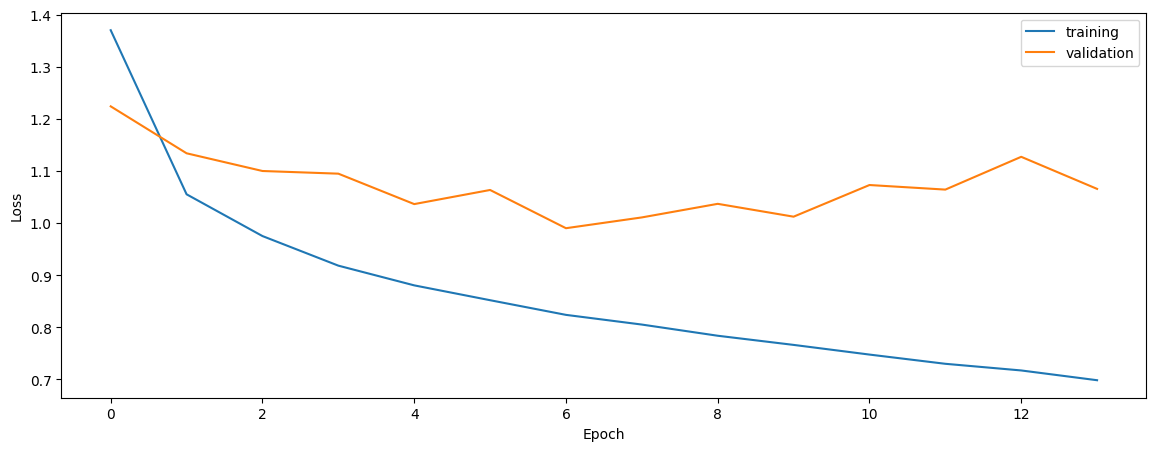

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


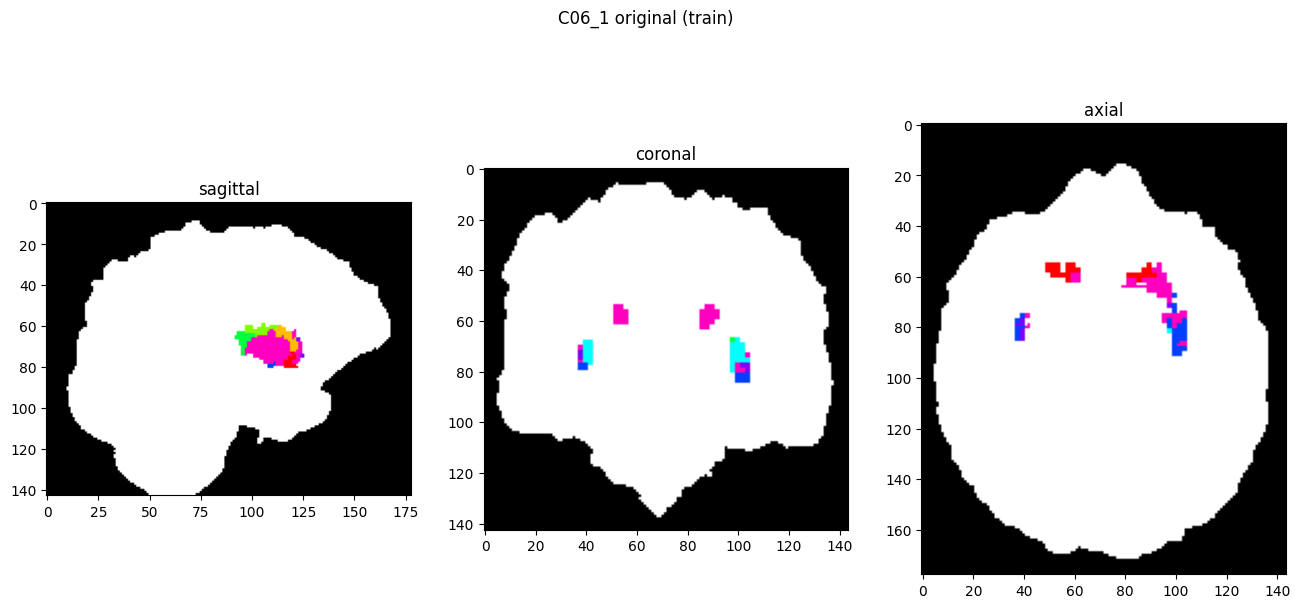

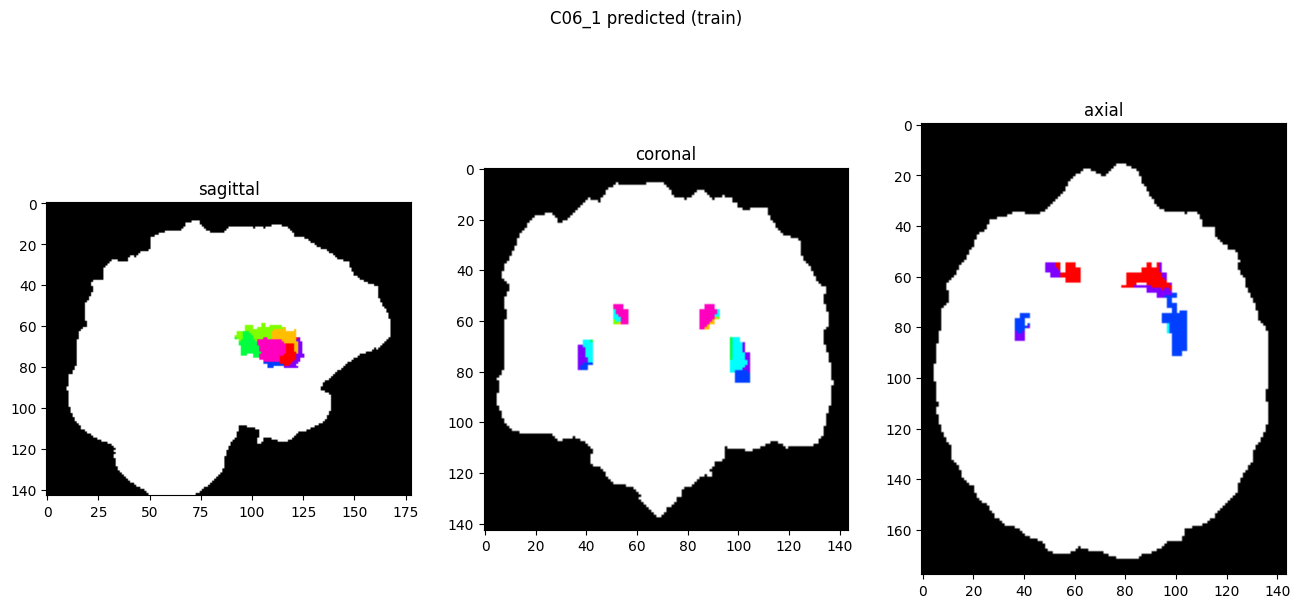

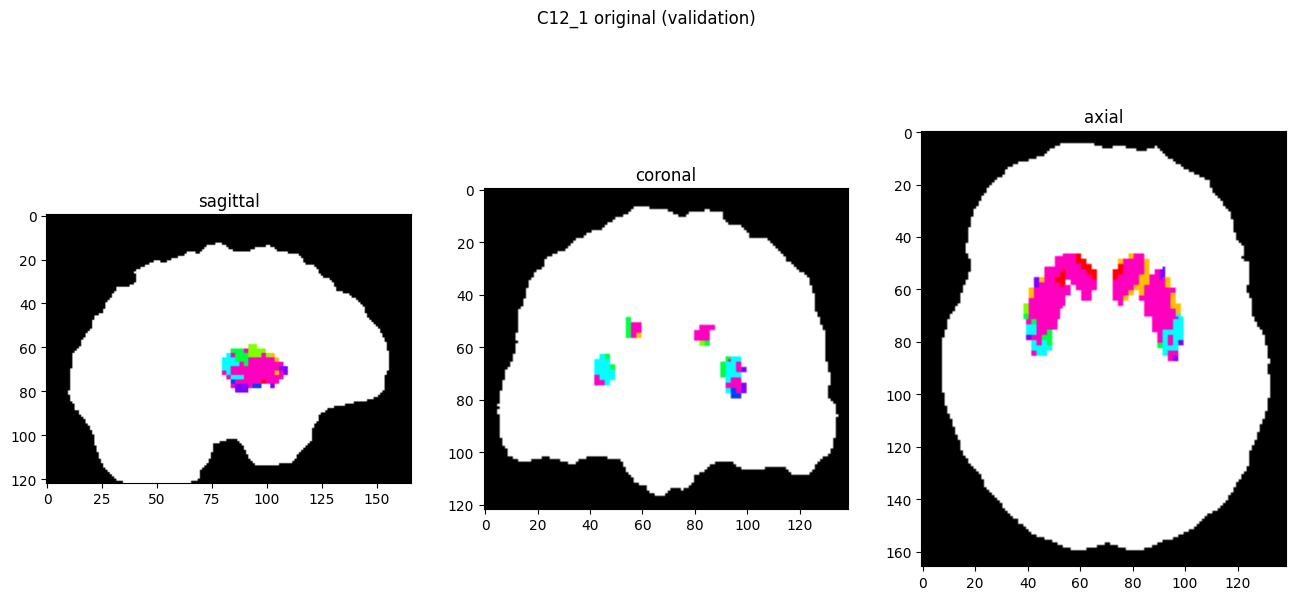

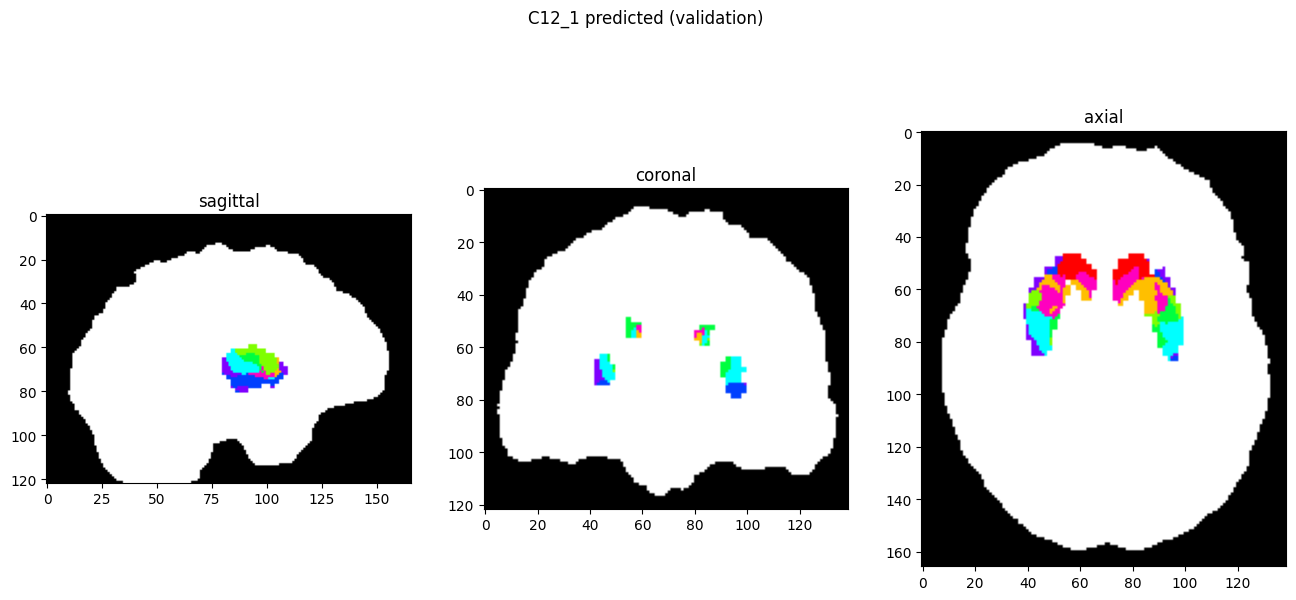

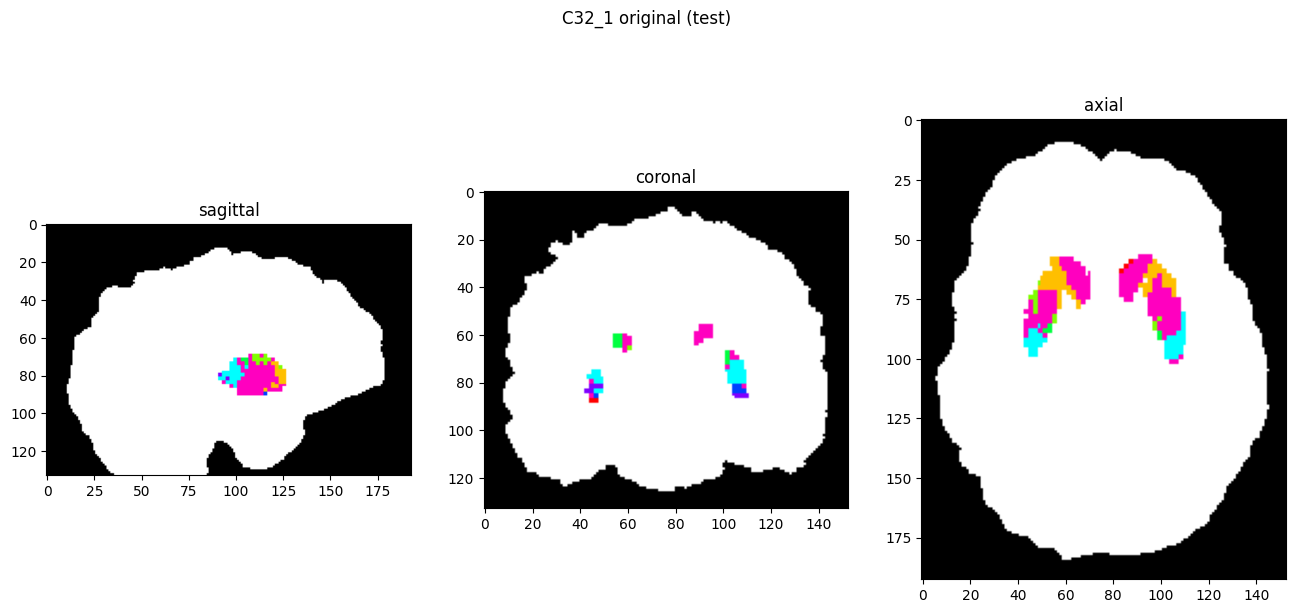

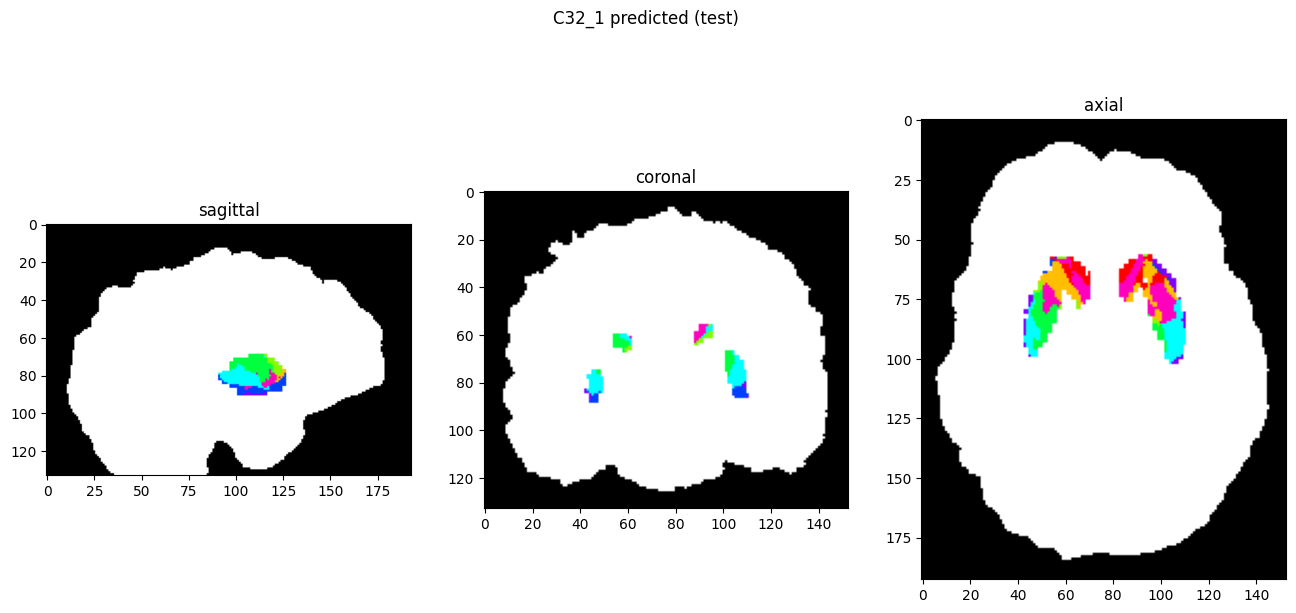

In [10]:
showResults(model, gen, threshold=0)